In [2]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'

import seaborn as sns

import sys,os,pdb,copy,pickle
from importlib import reload
# import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
sys.path.append('/mnt/home/szheng/projects/place_variability/code')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp


import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf

import switch_analysis_one_session as saos
reload(saos)

import process_central_arm as pca 
import change_point_analysis_central_arm_seperate as cpacas

import misc
reload(misc)
from misc import get_nth_key, get_nth_val

67 sessions!
67 sessions!


/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [3]:
import matplotlib
matplotlib.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.size'] = 10

In [4]:
figdir = '/mnt/home/szheng/ceph/place_variability/fig/paper/figure_cosw'
misc.get_or_create_subdir(figdir)
data_dir = '/mnt/home/szheng/ceph/place_variability/data/paper'
misc.get_or_create_subdir(data_dir)

/mnt/home/szheng/ceph/place_variability/fig/paper/figure_cosw
/mnt/home/szheng/ceph/place_variability/data/paper


'/mnt/home/szheng/ceph/place_variability/data/paper'

In [5]:
import database
db = database.db

subdb = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False).iloc[:1000]
subdb = subdb.query('ntrials>=20&n_neurons>=50')
to_exclude_sess = ['e16_3m2_211211']
subdb=subdb.loc[~subdb['sess_name'].isin(to_exclude_sess)]


import pf_recombine_central as pfrc
import fr_map_one_session as fmos
import switch_detection_one_session as sdos
reload(sdos)
import get_all_switch_add_metrics as gasam
reload(gasam)

import preprocess_one_session as prepos

In [4]:
%%time
all_fields_recombined_all = {}
pf_params_recombined_all = {}
fr_map_trial_df_all = {}
pval_all = {}
best_n_all = {}
X_pwc_all = {}
X_raw_all = {}
changes_df_all = {}
var_res_all = {}
corr_all = {}
all_sw_d_all = {}
all_sw_with_metrics_d_all = {}
trial_index_to_index_within_df_all = {}

spk_beh_df_all = {}

for ind,row in subdb.iterrows():
    data_dir_full = row['data_dir_full']
    ani = ind[0]
    sess = row['sess_name']
    
    res=dpp.load_spk_beh_df(data_dir_full,load_only=True)
    if res is not None:
        spk_beh_df = res['spk_beh_df']
        spk_beh_df,_ = dpp.add_lin_binned(spk_beh_df,bin_size=2.2,nbins=None)
        spk_beh_df_all[ani,sess] = spk_beh_df
        trial_index_to_index_within_df = dpp.trial_index_to_index_within_trialtype(spk_beh_df)
        trial_index_to_index_within_df_all[ani,sess] = trial_index_to_index_within_df
        

    pf_res_recombine = pfrc.main(data_dir_full,force_reload=False,load_only=True)

    all_fields_recombined=pf_res_recombine['all_fields_recombined']
    all_fields_recombined_all[ani,sess] = all_fields_recombined
    pf_params_recombined = pf_res_recombine['params_recombined']
    pf_params_recombined_all[ani,sess] = pf_params_recombined

    fr_map_all = fmos.main(data_dir_full,force_reload=False,load_only=True)
    fr_map_trial_df = fr_map_all['fr_map_trial_df']
    fr_map_trial_df_all[ani,sess] = fr_map_trial_df



    sw_res = sdos.main(data_dir_full,force_reload=False,load_only=True)
    pval = sw_res['pval']
    pval_all[ani,sess]=pval
    best_n = sw_res['best_n']
    best_n_all[ani,sess] = best_n
    X_pwc = sw_res['X_pwc']
    X_pwc_all[ani,sess] = X_pwc
    X_raw = sw_res['X_raw']
    X_raw_all[ani,sess]=X_raw
    changes_df = sw_res['changes_df']
    changes_df_all[ani,sess] = changes_df
    var_res = sw_res['var_res']
    var_res_all[ani,sess]=var_res
    corr = sw_res['corr']
    corr_all[ani,sess] = corr

    sw_info_res=gasam.main(data_dir_full,force_reload=False,load_only=True)
    if sw_info_res is None:
        sw_info_res=gasam.main(data_dir_full,force_reload=True,load_only=False)
    all_sw_d = sw_info_res['all_sw_d']
    all_sw_d_all[ani,sess] = all_sw_d
    all_sw_with_metrics_d = sw_info_res['all_sw_with_metrics_d']
    all_sw_with_metrics_d_all[ani,sess] = all_sw_with_metrics_d

all_fields_recombined_all = pd.concat(all_fields_recombined_all,axis=0)
pf_params_recombined_all = pd.concat(pf_params_recombined_all,axis=0)
fr_map_trial_df_all = pd.concat(fr_map_trial_df_all,axis=0)
pval_all = pd.concat(pval_all,axis=0)
X_pwc_all = pd.concat(X_pwc_all,axis=0)
X_raw_all = pd.concat(X_raw_all,axis=0)
changes_df_all = pd.concat(changes_df_all,axis=0)
var_res_all = pd.concat(var_res_all,axis=0)
corr_all = pd.concat(corr_all,axis=0)
all_sw_d_all = pd.concat(all_sw_d_all,axis=0)
all_sw_with_metrics_d_all = pd.concat(all_sw_with_metrics_d_all,axis=0)
best_n_all = pd.concat(best_n_all,axis=0)

spk_beh_df_all = pd.concat(spk_beh_df_all,axis=0)


/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/place_field_afterheadscan_recombine.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/fr_map.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/sw_res_afterheadscan.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/switch_analysis/all_sw_info.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/place_field_afterheadscan_recombine.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/fr_map.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/sw_res_afterheadscan.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/switch_analysis/all_sw_info.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220118

In [6]:
fn = 'prepped_data_agg.p'
fn_full = os.path.join(data_dir,fn)
prepped_data_agg = pickle.load(open(fn_full,'rb'))

all_fields_recombined_all = prepped_data_agg['all_fields_recombined_all']
pf_params_recombined_all=  prepped_data_agg['pf_params_recombined_all']
fr_map_trial_df_all= prepped_data_agg['fr_map_trial_df_all']
pval_all = prepped_data_agg['pval_all']
X_pwc_all = prepped_data_agg['X_pwc_all']
X_raw_all = prepped_data_agg['X_raw_all']
changes_df_all = prepped_data_agg['changes_df_all']
var_res_all = prepped_data_agg['var_res_all']
corr_all = prepped_data_agg['corr_all']
all_sw_d_all = prepped_data_agg['all_sw_d_all']
all_sw_with_metrics_d_all = prepped_data_agg['all_sw_with_metrics_d_all']
best_n_all = prepped_data_agg['best_n_all']
spk_beh_df_all = prepped_data_agg['spk_beh_df_all']
trial_index_to_index_within_df_all=prepped_data_agg['trial_index_to_index_within_df_all']

ntrials_per_tt=fr_map_trial_df_all.groupby(level=(0,1,2,3)).apply(lambda x:x.dropna(axis=1,how='all').shape[1])

ntrials_mask = ntrials_per_tt.groupby(level=(0,1,2)).apply(lambda x:(x>=7).all()) 

# distribution of switching per trial

In [19]:
gpb = changes_df_all.groupby(level=(0,1,2))

n_sw_on_per_trial_frac_all = {}
n_sw_off_per_trial_frac_all = {}

for k,val in gpb:
    val = val.dropna(axis=1,how='all').iloc[:,2:-2]
    n_avail_per_trial = val.notna().sum(axis=0)
    n_sw_on_per_trial = (val==1).sum(axis=0)
    n_sw_off_per_trial = (val==-1).sum(axis=0)
    
    n_sw_on_per_trial_frac = n_sw_on_per_trial / n_avail_per_trial
    n_sw_off_per_trial_frac = n_sw_off_per_trial / n_avail_per_trial
    
    n_sw_on_per_trial_frac_all[k] = n_sw_on_per_trial_frac
    n_sw_off_per_trial_frac_all[k] = n_sw_off_per_trial_frac
    
n_sw_on_per_trial_frac_all = pd.concat(n_sw_on_per_trial_frac_all)
n_sw_off_per_trial_frac_all = pd.concat(n_sw_off_per_trial_frac_all)
    
    

In [26]:
n_sw_on_per_trial_frac_all.loc[slice(None),slice(None),1]

e13_26m1  e13_26m1_211019  2     0.000000
                           3     0.000000
                           4     0.005714
                           5     0.018182
                           6     0.005714
                                   ...   
e16_3m2   e16_3m2_211213   22    0.032051
                           23    0.012821
                           24    0.021898
                           25    0.006410
                           26    0.007299
Length: 280, dtype: float64

In [53]:
n_sw_per_trial_frac_all = {'On':n_sw_on_per_trial_frac_all,'Off':n_sw_off_per_trial_frac_all}

On,0:0.010328630729368191
On,1:0.014929964261736787
Off,0:0.006652486150558635
Off,1:0.01020134709197806


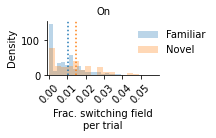

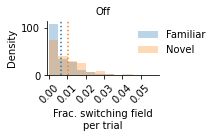

In [73]:

for sw,val in n_sw_per_trial_frac_all.items():
    fig,ax=plt.subplots(figsize=(2,1))
    for isnovel in [0,1]:
        famnov_str = {0:'Familiar',1:'Novel'}[isnovel]
        toplot = val[slice(None),slice(None),isnovel]
        print(f'{sw},{isnovel}:{toplot.mean()}')
        ax.hist(toplot,bins=30,alpha=0.3,density=True,label=famnov_str)
        mean = toplot.mean()
        ax.axvline(mean,linestyle=':',c=f'C{isnovel}')
    sns.despine()
    ax.set_xlim([-0.001,0.06])
    ax.set_xticks([0,0.01,0.02,0.03,0.04,0.05])
    xticklabels=ax.get_xticklabels()
    ax.set_xticklabels(xticklabels,rotation=45)
    ax.set_xlabel('Frac. switching field\nper trial')
    ax.set_ylabel('Density')
    ax.legend(bbox_to_anchor=[1.5,1],frameon=False)
    ax.set_title(sw)
    figfn = f'hist_frac_sw_per_trial_{sw}'
    ph.save_given_name(fig,figfn,figdir)
    

# coswitch summary figures 

In [6]:
import test_co_switch_one_sess as tcsos
reload(tcsos)
co_sw_pval_all = {}
n_co_sw_all={}
n_co_sw_shuffle_all={}
for ind,row in subdb.iterrows():
    data_dir_full = row['data_dir_full']
    ani = ind[0]
    sess = row['sess_name']
    cosw_res=tcsos.main(data_dir_full,force_reload=False,dosave=False,load_only=True)
    co_sw_pval = cosw_res['co_sw_pval']
    n_co_sw=cosw_res['n_co_sw']
    n_co_sw_shuffle=cosw_res['n_co_sw_shuffle']

    co_sw_pval_all[ani,sess]=co_sw_pval
    n_co_sw_all[ani,sess] = n_co_sw
    n_co_sw_shuffle_all[ani,sess] = n_co_sw_shuffle
co_sw_pval_all = pd.concat(co_sw_pval_all,axis=0)
n_co_sw_all = pd.concat(n_co_sw_all,axis=0)
n_co_sw_shuffle_all = pd.concat(n_co_sw_shuffle_all,axis=0)

co_sw_pval_all = co_sw_pval_all.loc[ntrials_mask]
n_co_sw_all=n_co_sw_all.loc[ntrials_mask]
n_co_sw_shuffle_all = n_co_sw_shuffle_all.loc[ntrials_mask]

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/co_sw_res_afterheadscan_fr_peak.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/co_sw_res_afterheadscan_fr_peak.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220118/py_data/co_sw_res_afterheadscan_fr_peak.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220119/py_data/co_sw_res_afterheadscan_fr_peak.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220120/py_data/co_sw_res_afterheadscan_fr_peak.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_211019/py_data/co_sw_res_afterheadscan_fr_peak.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210328/py_data/co_sw_res_afterheadscan_fr_peak.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_211116/py_data/co_sw_res_afterheadscan_fr_peak.p exists; loa

In [7]:
import test_co_switch as tcs
reload(tcs)
n_co_sw_shuffle_all_summary=tcs.get_shuffle_summary_combine_with_data(n_co_sw_all,n_co_sw_shuffle_all)

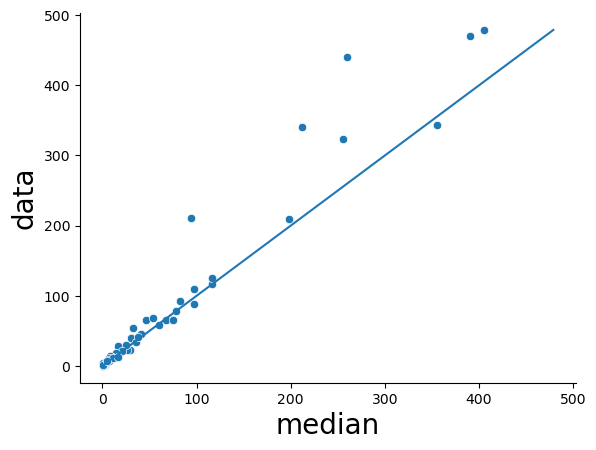

In [193]:
# plot one combo of onoff, triallag, intuple
onoff = 1
n_trial_lag = 0
n_in_tuple = 2
toplot=n_co_sw_shuffle_all_summary.loc[(slice(None),slice(None),slice(None),onoff,n_trial_lag,n_in_tuple),:]

ax=sns.scatterplot(data=toplot,x='median',y='data')
sns.despine()
max=toplot[['median','data']].max().max()
ax.plot([0,max],[0,max])


In [292]:
issig.mean()

0.34782608695652173

In [8]:
import matplotlib
def plot_n_cosw_data_vs_shuffle_one_setup(co_sw_pval_all,n_co_sw_shuffle_all_summary,pthresh=0.05,
                                        task_ind = 0,
                                        onoff = 1,
                                        n_trial_lag = 1,
                                        n_in_tuple = 3,
                                        fig=None,ax=None
                                        ):
    '''
    co_sw_pval_all: loaded from co_sw_pval from test_co_switch_one_sess.main
    then concat
    n_co_sw_shuffle_all_summary: from get_shuffle_summary_combine_with_data
    
    '''
    onoff_str_d={1:'ON',-1:'OFF'}
    if ax is None:
        fig,ax=plt.subplots()
    ax.set_aspect('equal')

    issig=co_sw_pval_all.loc[(slice(None),slice(None),task_ind,onoff,n_trial_lag,n_in_tuple)]<pthresh
    toplot =n_co_sw_shuffle_all_summary.loc[(slice(None),slice(None),task_ind, onoff,n_trial_lag,n_in_tuple),:]

    c = [matplotlib.colors.to_rgb('C0') if i else matplotlib.colors.to_rgb('C0') for i in issig]
    c_dict = {True:'C3',False:'C2'}
    label_d = {True:'significant',False:'not sig.'}
    for tf in [True,False]:
        ma = issig == tf
        toplot_ma = toplot.loc[ma]

        errorbar=toplot_ma[['ci_low','ci_high']].T - toplot_ma['median']
        errorbar = [-errorbar.iloc[0],errorbar.iloc[1]]
        c = c_dict[tf]
        ax.errorbar(toplot_ma['median'],toplot_ma['data'],xerr = errorbar,fmt='o',
                errorevery=1,c=c,label=label_d[tf],alpha=0.7,ms=5.
               )
    max_val = toplot[['median','data']].max().max()
    ax.plot([0,max_val],[0,max_val],color='k',linestyle=':',label='data=shuffle')
    ax.plot([0,0.5*max_val],[0,max_val],color='k',linestyle='-.',label='2-fold increase')
    ax.plot([0,1/3*max_val],[0,max_val],color='k',linestyle='--',label='3-fold increase')
    ax.spines[['top','right']].set_visible(False)
    ax.set_xlabel(f'Num. coswitching {onoff_str_d[onoff]} {n_in_tuple}-tuple (shuffled)')
    ax.set_ylabel(f'Num. coswitching {onoff_str_d[onoff]} {n_in_tuple}-tuple')
    ax.legend(bbox_to_anchor=[1,1.05])
    
    fraction = issig.mean()
    n_sig=issig.astype(int).sum()
    tot=issig.shape[0]
    ax.text(0.4,0.2,f'frac. of significant={n_sig}/{tot}\n={fraction:.02f}',transform=ax.transAxes,fontsize=15)
    
    return fig,ax,fraction




In [9]:
import matplotlib
from matplotlib.lines import Line2D
def plot_n_cosw_data_vs_shuffle_one_setup_bothonoff(co_sw_pval_all,n_co_sw_shuffle_all_summary,pthresh=0.05,
                                        task_ind = 0,
                                        n_trial_lag = 1,
                                        n_in_tuple = 2,
                                        fig=None,ax=None,
                                                    fs=10,figsize=(1.5,1.5)
                                        ):
    '''
    co_sw_pval_all: loaded from co_sw_pval from test_co_switch_one_sess.main
    then concat
    n_co_sw_shuffle_all_summary: from get_shuffle_summary_combine_with_data
    
    '''
    onoff_str_d={1:'ON',-1:'OFF'}
    if ax is None:
#         fig,ax=plt.subplots(figsize=(7,4))
        fig,ax=plt.subplots(figsize=figsize)
    ax.set_aspect('equal')

    
    onoff_fmt_d = {1:'o',-1:'x'}
    ms = 4
    ms_d={True:4,False:2}
    for onoff in [1,-1]:
        issig=co_sw_pval_all.loc[(slice(None),slice(None),task_ind,onoff,n_trial_lag,n_in_tuple)]<pthresh
        toplot =n_co_sw_shuffle_all_summary.loc[(slice(None),slice(None),task_ind, onoff,n_trial_lag,n_in_tuple),:]

        c = [matplotlib.colors.to_rgb('C0') if i else matplotlib.colors.to_rgb('C0') for i in issig]
        c_dict = {True:'C3',False:'C0'}
        label_d = {True:'significant',False:'not sig.'}
        for tf in [False,True]:
            ma = issig == tf
            toplot_ma = toplot.loc[ma]

            errorbar=toplot_ma[['ci_low','ci_high']].T - toplot_ma['median']
            errorbar = [-errorbar.iloc[0],errorbar.iloc[1]]
            c = c_dict[tf]
            if tf:
                alpha=0.7
            else:
                alpha=0.5
            ax.errorbar(toplot_ma['median'],toplot_ma['data'],xerr = errorbar,fmt=onoff_fmt_d[onoff],
                    errorevery=1,c=c,label=label_d[tf],alpha=alpha,ms=ms_d[tf],elinewidth=0.5,markeredgewidth=1
                   )
        
        fraction = issig.mean()
        n_sig=issig.astype(int).sum()
        tot=issig.shape[0]
        if onoff==1:
            text = f'frac. significant\n{onoff_str_d[onoff]}\n={n_sig}/{tot}={fraction:.02f}'
        else:
            text = f'{onoff_str_d[onoff]}\n={n_sig}/{tot}={fraction:.02f}'
        ax.text(0.6,0.2+onoff * 0.1,text,transform=ax.transAxes,fontsize=fs)
        
    max_val = toplot[['median','data']].max().max()
    ax.plot([0,max_val],[0,max_val],color='k',linestyle=':',label='data=shuffle',alpha=0.5,linewidth=0.5)
    ax.plot([0,0.5*max_val],[0,max_val],color='k',linestyle='-.',label='2-fold increase',alpha=0.5,linewidth=0.5)
#     ax.plot([0,1/3*max_val],[0,max_val],color='k',linestyle='--',label='3-fold increase')
    ax.spines[['top','right']].set_visible(False)
#     ax.set_xlabel(f'Num. coswitching {n_in_tuple}-tuple (shuffled)') # used to have different options for n_in_tuple
#     ax.set_ylabel(f'Num. coswitching {n_in_tuple}-tuple')
#     ax.set_xlabel(f'Num. coswitching pairs (shuffled)')
    ax.set_xlabel(f'Shuffle')
    ax.set_ylabel(f'Num. coswitching pairs\nData')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()
    
    legend_elements = [Line2D([0], [0], marker='o', color='black', label='ON', markersize=ms, linestyle='None'),
                   Line2D([0], [0], marker='x', color='black', label='OFF', markersize=ms, linestyle='None')]

    # Add the custom legend handles to the existing legend
    ax.legend(handles=ax.get_legend_handles_labels()[0][:-2] + legend_elements,
              labels=ax.get_legend_handles_labels()[1][:-2] + ['ON', 'OFF'],
              bbox_to_anchor=[1.1,1.05],frameon=False,fontsize=fs
             )

    
    
    
    return fig,ax,fraction




In [152]:
# sns.reset_defaults()
# plt.rcParams['svg.fonttype']='none'
# current_rc_params = plt.rcParams.copy()
# # Set the font scale (font size) you want to use
# font_scale = 1
# plt.rcParams.update({'font.size': current_rc_params['font.size'] * font_scale})

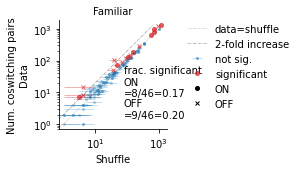

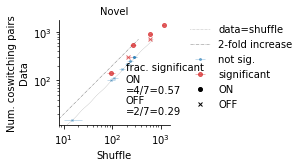

In [19]:
isnovel_str_d={0:'Familiar',1:'Novel'}
for task_ind in [0,1]:
    fig,ax,fraction=plot_n_cosw_data_vs_shuffle_one_setup_bothonoff(co_sw_pval_all,n_co_sw_shuffle_all_summary,pthresh=0.05,
                                        task_ind = task_ind,
                                        n_trial_lag = 1,
                                        n_in_tuple = 2,
                                        fig=None,ax=None,fs=10,figsize=(2,2)
                                        )
    ax.set_title(isnovel_str_d[task_ind])
    figfn = f'n_cosw_pairs_vs_shuffle_isnovel{task_ind}_bothonoff'
    ph.save_given_name(fig,figfn,figdir)
#     for fmt in ['svg','png']:
#         fn_full =f'n_cosw_pairs_vs_shuffle_isnovel{task_ind}_bothonoff.{fmt}'
#         fn_full=os.path.join(figdir,fn_full)
#         fig.savefig(fn_full,bbox_inches='tight')
        

In [242]:
co_sw_pval_all.loc[slice(None),slice(None),slice(None),-1,0,2].sort_values()

e13_26m1  e13_26m1_210913  0    0.000
e15_13f1  e15_13f1_220119  1    0.000
e14_2m2   e14_2m2_201017   0    0.000
e15_10m1  e15_10m1_200803  0    0.001
e13_26m1  e13_26m1_211019  1    0.002
e15_13f1  e15_13f1_220118  0    0.004
          e15_13f1_220120  0    0.010
          e15_13f1_220118  1    0.011
          e15_13f1_220117  0    0.022
e16_3m2   e16_3m2_211210   0    0.024
e13_26m1  e13_26m1_211019  0    0.040
          e13_26m1_211119  0    0.048
e16_3m1   e16_3m1_210203   0    0.054
e14_2m3   e14_2m3_201206   0    0.056
e13_26m1  e13_26m1_211124  0    0.069
e16_3m2   e16_3m2_211213   0    0.070
e15_9f1   e15_9f1_200715   0    0.083
e14_2m2   e14_2m2_201019   0    0.095
e13_16f1  e13_16f1_210314  0    0.100
          e13_16f1_210322  0    0.102
e16_1f1   e16_1f1_201004   0    0.106
e15_9f1   e15_9f1_200729   0    0.107
e16_3m2   e16_3m2_211212   0    0.176
e13_16f1  e13_16f1_210302  0    0.184
e15_13f1  e15_13f1_220119  0    0.196
e14_2m3   e14_2m3_201118   0    0.223
e13_16f1  e1

In [238]:
co_sw_pval_all.loc[slice(None),slice(None),slice(None),1,0,2].sort_values()

e13_26m1  e13_26m1_210913  0    0.000
e15_13f1  e15_13f1_220119  1    0.000
                           0    0.000
e13_26m1  e13_26m1_211019  1    0.000
e15_13f1  e15_13f1_220118  0    0.000
                           1    0.001
e16_3m2   e16_3m2_211212   1    0.002
          e16_3m2_211213   0    0.013
e13_16f1  e13_16f1_210314  0    0.017
e16_2m1   e16_2m1_201121   0    0.030
e16_1f1   e16_1f1_200920   0    0.034
e16_3m2   e16_3m2_211210   0    0.041
e16_3m1   e16_3m1_210203   0    0.073
e14_2m3   e14_2m3_201129   0    0.134
e15_13f1  e15_13f1_220120  1    0.145
e13_16f1  e13_16f1_210319  0    0.146
e16_3m2   e16_3m2_211213   1    0.153
e15_10m1  e15_10m1_200803  0    0.186
          e15_10m1_200727  0    0.190
e13_16f1  e13_16f1_210312  0    0.195
          e13_16f1_210328  0    0.212
e14_2m3   e14_2m3_201118   0    0.223
e15_13f1  e15_13f1_220120  0    0.235
e15_9f1   e15_9f1_200729   0    0.244
e16_3m1   e16_3m1_210119   0    0.302
e15_9f1   e15_9f1_200802   0    0.319
e14_2m3   e1

# one trial, sequence

In [10]:
import plot_ratemap_sequence as prs

In [181]:
reload(prs)

<module 'plot_ratemap_sequence' from '/mnt/home/szheng/projects/util_code/plot_ratemap_sequence.py'>

In [11]:
def get_coswitching_field_one_trial(trial_index,changes_df,all_fields,trial_index_to_index_within_df,
                                    task_ind=0,onoff=1,
                                   ):
    tt_ind_within=trial_index_to_index_within_df.loc[task_ind,slice(None),trial_index]
    tt=tt_ind_within.index[0]
    index_within=tt_ind_within.values[0]
    all_index_within = trial_index_to_index_within_df.loc[task_ind,tt].values # sometimes it's not the same as arange, because some trials are dropped as bad trials
    index_within_within = np.nonzero(all_index_within==index_within)[0][0]
    cd_sub=changes_df.loc[task_ind,trial_index].dropna()==onoff
    uid_field_l=cd_sub.index[cd_sub]
    uid_l = uid_field_l.get_level_values(1)
    field_pos_l = all_fields.loc[task_ind].loc[uid_field_l]['peak']
    uid_field_l_sorted = field_pos_l.sort_values().index
    uid_l_sorted=uid_field_l_sorted.get_level_values(1)
    
    return tt,index_within,index_within_within,uid_l_sorted,uid_field_l_sorted
    

In [12]:
def plot_sequence_around_switch(trial_index,fr_map_trial_df,changes_df,all_fields,
                                trial_index_to_index_within_df,
                                task_ind=0,onoff=1,
                                norm_fr_map_per_neuron=True,n_tr_to_show=5,fig=None,axs=None):

    tt,index_within,index_within_within,uid_l_sorted,uid_field_l_sorted = get_coswitching_field_one_trial(trial_index,changes_df,all_fields,trial_index_to_index_within_df,
                                    task_ind=task_ind,onoff=onoff)

#     tt_ind_within=trial_index_to_index_within_df.loc[task_ind,slice(None),trial_index]
#     tt=tt_ind_within.index[0]
#     index_within=tt_ind_within.values[0]
    all_index_within = trial_index_to_index_within_df.loc[task_ind,tt].values # sometimes it's not the same as arange, because some trials are dropped as bad trials
#     index_within_within = np.nonzero(all_index_within==index_within)[0][0]
#     cd_sub=changes_df.loc[task_ind,trial_index].dropna()==onoff
#     uid_field_l=cd_sub.index[cd_sub]
#     uid_l = uid_field_l.get_level_values(1)
#     field_pos_l = all_fields.loc[task_ind].loc[uid_field_l]['peak']
#     uid_field_l_sorted = field_pos_l.sort_values().index
#     uid_l_sorted=uid_field_l_sorted.get_level_values(1)
    
    
    
    if norm_fr_map_per_neuron:
        fr_map_trial_df_norm = fr_map_trial_df.groupby(level=(0,1,2)).apply(lambda x:x/(x.max().max()))
    else:
        fr_map_trial_df_norm = fr_map_trial_df
    if axs is None:
        fig,axs=plt.subplots(1,n_tr_to_show,figsize=(4*n_tr_to_show,4),sharey=True)

    order = uid_l_sorted
    vmax = 1
    
    for ii in range(n_tr_to_show):
        try:
            tr = index_within_within - (n_tr_to_show//2)+ii # get the index within all_index_within
            tr = all_index_within[tr] # translate it into index_within
#             tr = index_within-(n_tr_to_show//2)+ii
            sub_pop_ratemap_one_trial=fr_map_trial_df_norm.loc[(task_ind,tt,uid_l_sorted),tr].unstack(level=-1).droplevel((0,1))
            vmax_=sub_pop_ratemap_one_trial.max().max() * 0.9
            if vmax_ >vmax:
                vmax=vmax_
        except:
            pass
    for ii in range(n_tr_to_show):
        try:
#             tr = index_within-(n_tr_to_show//2)+ii
            tr = index_within_within - (n_tr_to_show//2)+ii
            tr = all_index_within[tr]
            ax=axs[ii]
            sub_pop_ratemap_one_trial=fr_map_trial_df_norm.loc[(task_ind,tt,uid_l_sorted),tr].unstack(level=-1).droplevel((0,1))
            fig,ax,order=prs.plot_population_sequence(sub_pop_ratemap_one_trial,order=order,normalize=False,fig=fig,ax=ax,vmax=vmax)
            
            title=tr-index_within
            if title==0:
                title='Switch trial'
            elif title>0:
                title=f'+{title}'
            ax.set_title(title)
            
        except Exception as e:
            print(e)
            pass
    
    axs[0].set_ylabel('Neuron')
    fig.supxlabel('Position Bin',fontsize=15)
    plt.tight_layout()
    
    return fig,axs, uid_field_l_sorted,tt,index_within
    

# fix one session, onoff, trial_index, get all plots

In [62]:
co_sw_pval_all

                              onoff  n_trial_lag  n_in_tuple
e13_26m1  e13_26m1_210913  0   1     0            2             0.000
                                                  3             0.004
                                                  4             0.008
                                     1            2             0.009
                                                  3             0.001
                                                                ...  
e14_2m3   e14_2m3_201118   0  -1     1            3             0.314
                                                  4             1.000
                                     2            2             0.318
                                                  3             0.312
                                                  4             0.316
Length: 954, dtype: float64

In [ ]:
changes_df_all.loc[]

In [124]:
co_sw_pval_all.loc[(slice(None),'e15_13f1_220117')]

             onoff  n_trial_lag  n_in_tuple
e15_13f1  0   1     0            2             0.732
                                 3             0.474
                                 4             0.277
                    1            2             0.926
                                 3             0.813
                                 4             0.645
                    2            2             0.976
                                 3             0.922
                                 4             0.836
             -1     0            2             0.022
                                 3             0.022
                                 4             0.033
                    1            2             0.073
                                 3             0.059
                                 4             0.076
                    2            2             0.051
                                 3             0.054
                                 4             0.074
dt

In [68]:
sig_sess_d = {}
for onoff in [1,-1]:
    co_sw_pval_sub=co_sw_pval_all.loc[slice(None),slice(None),0,onoff,0,2].sort_values().head(10)
#     co_sw_pval_sub = co_sw_pval_sub.loc[co_sw_pval_sub<0.05]
    sig_sess=co_sw_pval_sub.index
    sig_sess_d[onoff]=sig_sess
    print(onoff)
    display(co_sw_pval_sub)


1


e13_26m1  e13_26m1_210913    0.000
e15_13f1  e15_13f1_220118    0.000
          e15_13f1_220119    0.000
e16_3m2   e16_3m2_211213     0.013
e13_16f1  e13_16f1_210314    0.017
e16_2m1   e16_2m1_201121     0.030
e16_1f1   e16_1f1_200920     0.034
e16_3m2   e16_3m2_211210     0.041
e16_3m1   e16_3m1_210203     0.073
e14_2m3   e14_2m3_201129     0.134
dtype: float64

-1


e13_26m1  e13_26m1_210913    0.000
e14_2m2   e14_2m2_201017     0.000
e15_10m1  e15_10m1_200803    0.001
e15_13f1  e15_13f1_220118    0.004
          e15_13f1_220120    0.010
          e15_13f1_220117    0.022
e16_3m2   e16_3m2_211210     0.024
e13_26m1  e13_26m1_211019    0.040
          e13_26m1_211119    0.048
e16_3m1   e16_3m1_210203     0.054
dtype: float64

In [67]:
sig_sess_d[onoff]

MultiIndex([('e13_26m1', 'e13_26m1_210913'),
            ('e15_13f1', 'e15_13f1_220118'),
            ('e15_13f1', 'e15_13f1_220119'),
            ( 'e16_3m2',  'e16_3m2_211213'),
            ('e13_16f1', 'e13_16f1_210314'),
            ( 'e16_2m1',  'e16_2m1_201121'),
            ( 'e16_1f1',  'e16_1f1_200920'),
            ( 'e16_3m2',  'e16_3m2_211210')],
           )

In [73]:
changes_summed.loc[slice(None),slice(None),0].loc[sig_sess_d[onoff]]

4   5   6   7   8   9   10  11  12  13  14  15  16  \
e13_26m1 e13_26m1_210913   6   1   4  11   8  10   5   7   2   6   2   4   2   
e15_13f1 e15_13f1_220118   5   6   2   2   6   3   4   4   2   3   4   3   6   
         e15_13f1_220119   1   4   0   3  18   2   6   0  12  17   3   3   4   
e16_3m2  e16_3m2_211213    5   0   1   0   5   1   2   0   5   0   3   2   4   
e13_16f1 e13_16f1_210314   1   1   0   0   1   1   0   4   6   2   0   0   1   
e16_2m1  e16_2m1_201121    0   0   0   0   0   1   0   0   0   0   0   2   0   
e16_1f1  e16_1f1_200920    0   0   0   2   0   0   0   2   0   1   3   0   1   
e16_3m2  e16_3m2_211210    0   2   1   4   0   4   5   1   2   1   1   2   2   
e16_3m1  e16_3m1_210203    1   2   3   0   1   0   5   1   7   0   3   1   0   
e14_2m3  e14_2m3_201129    0   3   0   1   2   1   0   0   0   1   0   0   0   

                          17  18  19  20  
e13_26m1 e13_26m1_210913   1   3   6   4  
e15_13f1 e15_13f1_220118   5   5  18   5  
         e15_13f1_220119   3   3   1   3  
e16_3m2  e16_3m2_211213    2   1   7   1  
e13_16f1 e13_16f1_210314   1   0   0   1  
e16_2m1  e16_2m1_201121    0   1   3   0  
e16_1f1  e16_1f1_200920    4   0   3   0  
e16_3m2  e16_3m2_211210    3   4   8   4  
e16_3m1  e16_3m1_210203    2   2   1   0  
e14_2m3  e14_2m3_201129    2   0   1   4

In [74]:
for onoff in [1,-1]:
    changes_summed=changes_df_all.groupby(level=(0,1,2)).apply(lambda x: (x==onoff).sum(axis=0)).loc[:,4:20]
    print(onoff)
    display(changes_summed.loc[slice(None),slice(None),0].loc[sig_sess_d[onoff]])
    
    

1


4   5   6   7   8   9   10  11  12  13  14  15  16  \
e13_26m1 e13_26m1_210913   6   1   4  11   8  10   5   7   2   6   2   4   2   
e15_13f1 e15_13f1_220118   5   6   2   2   6   3   4   4   2   3   4   3   6   
         e15_13f1_220119   1   4   0   3  18   2   6   0  12  17   3   3   4   
e16_3m2  e16_3m2_211213    5   0   1   0   5   1   2   0   5   0   3   2   4   
e13_16f1 e13_16f1_210314   1   1   0   0   1   1   0   4   6   2   0   0   1   
e16_2m1  e16_2m1_201121    0   0   0   0   0   1   0   0   0   0   0   2   0   
e16_1f1  e16_1f1_200920    0   0   0   2   0   0   0   2   0   1   3   0   1   
e16_3m2  e16_3m2_211210    0   2   1   4   0   4   5   1   2   1   1   2   2   
e16_3m1  e16_3m1_210203    1   2   3   0   1   0   5   1   7   0   3   1   0   
e14_2m3  e14_2m3_201129    0   3   0   1   2   1   0   0   0   1   0   0   0   

                          17  18  19  20  
e13_26m1 e13_26m1_210913   1   3   6   4  
e15_13f1 e15_13f1_220118   5   5  18   5  
         e15_13f1_220119   3   3   1   3  
e16_3m2  e16_3m2_211213    2   1   7   1  
e13_16f1 e13_16f1_210314   1   0   0   1  
e16_2m1  e16_2m1_201121    0   1   3   0  
e16_1f1  e16_1f1_200920    4   0   3   0  
e16_3m2  e16_3m2_211210    3   4   8   4  
e16_3m1  e16_3m1_210203    2   2   1   0  
e14_2m3  e14_2m3_201129    2   0   1   4

-1


4   5   6   7   8   9   10  11  12  13  14  15  16  \
e13_26m1 e13_26m1_210913   9   7   7   5   7  14   9   5   5   3   6   4   4   
e14_2m2  e14_2m2_201017   15   0   0   1   1   0   1   1   0   0   0   0   0   
e15_10m1 e15_10m1_200803   1   0   0   0   0   0   0   0   2   4   0   0   0   
e15_13f1 e15_13f1_220118   5   8   3   1   1   0   0   4   1   1   1   0   3   
         e15_13f1_220120   0   4   3   1   0   0   2   1   0   0   1   1   0   
         e15_13f1_220117   3   1   1   1   3   5   3   7   1   1   4   2   1   
e16_3m2  e16_3m2_211210    5   3   6   2   2   1   2   0   0   1   0   0   2   
e13_26m1 e13_26m1_211019   3   8   1   1   2   2   0   4   0   2   3   0   4   
         e13_26m1_211119   6   4   1   0   0   1   3   3   4   0   0   2   1   
e16_3m1  e16_3m1_210203    0   0   6   0   0   2   0   1   0   1   1   1   3   

                          17  18  19  20  
e13_26m1 e13_26m1_210913   5   4   4   5  
e14_2m2  e14_2m2_201017    2   0   0   0  
e15_10m1 e15_10m1_200803   0   0   0   0  
e15_13f1 e15_13f1_220118   1   0   3   3  
         e15_13f1_220120   3   0   0   2  
         e15_13f1_220117   8   3   1   5  
e16_3m2  e16_3m2_211210    0   0   3   1  
e13_26m1 e13_26m1_211019   2   1   0   1  
         e13_26m1_211119   2   2   2   4  
e16_3m1  e16_3m1_210203    1   1   4   0

In [103]:
# fraction of switching fields per trial all
gpb=changes_df_all.groupby(level=(0,1,2))
frac_all = {}
onoff = 1
for k,val in gpb:
    frac = (val==onoff).sum(axis=0) / val.notna().sum(axis=0)
    frac_all[k] = frac
frac_all = pd.concat(frac_all)

In [104]:
frac_all

e13_16f1  e13_16f1_210302  0  0     0.000000
                              1     0.000000
                              2     0.005848
                              3     0.005848
                              4     0.032432
                                      ...   
e16_3m2   e16_3m2_211213   1  65         NaN
                              66         NaN
                              67         NaN
                              68         NaN
                              69         NaN
Length: 3780, dtype: float64

(array([625., 292., 146.,  75.,  46.,  30.,   8.,  11.,   1.,   2.]),
 array([0.        , 0.00652174, 0.01304348, 0.01956522, 0.02608696,
        0.0326087 , 0.03913043, 0.04565217, 0.05217391, 0.05869565,
        0.06521739]),
 <BarContainer object of 10 artists>)

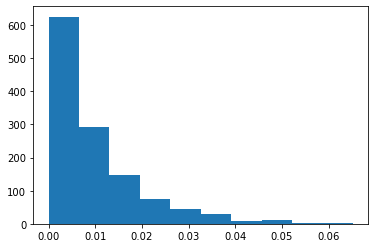

In [105]:
xx = frac_all.loc[(slice(None),slice(None),0)].dropna().values
plt.hist(xx)

In [111]:
frac_all.quantile(0.75)

0.015228426395939087

In [169]:
changes_df_all.loc[('e13_26m1','e13_26m1_211116',1)].dropna(axis=1,how='all')

/tmp/ipykernel_374785/3951620695.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  changes_df_all.loc[('e13_26m1','e13_26m1_211116',1)].dropna(axis=1,how='all')


0    1    2    3    4    5    6    7    8
0.0 5   0  0.0  NaN  0.0  NaN  0.0  NaN  0.0  NaN  0.0
    10  0  0.0  NaN  0.0  NaN  0.0  NaN  0.0  NaN  0.0
    11  0  0.0  NaN  0.0  NaN  0.0  NaN  0.0  NaN  0.0
    16  0  0.0  NaN  0.0  NaN  0.0  NaN  0.0  NaN  0.0
    17  0  0.0  NaN  0.0  NaN  0.0  NaN  0.0  NaN  0.0
...        ...  ...  ...  ...  ...  ...  ...  ...  ...
1.0 189 0  NaN  0.0  NaN  0.0  NaN  0.0  NaN  0.0  NaN
    194 1  NaN  0.0  NaN  0.0  NaN -1.0  NaN  0.0  NaN
    196 0  NaN  0.0  NaN  0.0  NaN  0.0  NaN  0.0  NaN
    199 0  NaN  0.0  NaN  0.0  NaN  0.0  NaN  0.0  NaN
    201 0  NaN  0.0  NaN  0.0  NaN  0.0  NaN  0.0  NaN

[117 rows x 9 columns]

In [175]:
frac_all.sort_values(ascending=False).head(20)

e13_26m1  e13_26m1_211116  1  4     0.098592
          e13_26m1_211019  1  28    0.085714
e16_3m2   e16_3m2_211212   1  12    0.081967
                              17    0.065574
e16_1f1   e16_1f1_200918   0  14    0.065217
          e16_1f1_200920   0  17    0.064516
e13_26m1  e13_26m1_211119  1  7     0.056338
          e13_26m1_211019  1  24    0.054545
                              27    0.054545
e15_13f1  e15_13f1_220119  0  8     0.052786
e15_9f1   e15_9f1_200715   0  9     0.051724
                              12    0.051724
                              8     0.051724
e15_13f1  e15_13f1_220119  0  13    0.049853
          e15_13f1_220118  0  19    0.049315
e16_3m2   e16_3m2_211212   1  20    0.049180
                              16    0.049180
                              10    0.049180
e14_2m3   e14_2m3_201129   0  20    0.048780
e13_16f1  e13_16f1_210312  0  9     0.048387
dtype: float64

In [107]:
frac_all.median()

0.0069368704689805605

### sequence

In [20]:
trial_index_to_index_within_df_all[ani,sess].loc[0]

tt_ind  trial_ind
0.0     1.0           0
        2.0           1
        4.0           2
        5.0           3
        7.0           4
        9.0           5
        10.0          6
        12.0          7
        15.0          8
        16.0          9
        18.0         10
        20.0         11
        22.0         12
        23.0         13
        25.0         14
        27.0         15
        28.0         16
        29.0         17
        30.0         18
1.0     0.0           0
        3.0           1
        8.0           3
        13.0          5
        14.0          6
        17.0          7
        19.0          8
        21.0          9
        24.0         10
        26.0         11
Name: index, dtype: int64

ON ex 1:
'e13_26m1_210913'
onoff=1
trial_index=7
task_ind=0

ON ex 2:



In [121]:
tt,index_within,index_within_within,uid_l_sorted,uid_field_l_sorted = prs.get_coswitching_field_one_trial(11,changes_df,all_fields,trial_index_to_index_within_df,
                                    task_ind=task_ind,onoff=onoff)

In [122]:
uid_field_l_sorted

MultiIndex([('both', 64, 0)],
           names=[None, None, 'field_index'])

In [55]:
trial_index

11

In [56]:
changes_df[trial_index]==1

0  0.0   11   1    False
         27   0    False
              1    False
              3    False
         35   1    False
                   ...  
1  both  250  0    False
         252  0    False
         253  0    False
         261  0    False
         266  0    False
Name: 11, Length: 805, dtype: bool

In [131]:
(changes_df.dropna(axis=1,how='all')==1).sum(axis=0)

0      0
1      0
2      5
3      2
4      5
5      4
6      6
7      2
8      4
9      9
10     9
11     5
12     5
13     6
14     6
15     4
16     4
17     6
18     7
19     4
20     4
21     6
22     1
23     3
24     4
25     1
26     5
27     2
28     4
29     4
30    12
31     0
dtype: int64

In [136]:
data_dir_full = subdb.loc[subdb['sess_name']==sess]['data_dir_full'][0]
cosw_res=tcsos.main(data_dir_full,force_reload=True,dosave=False,load_only=False)

/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/sw_res_afterheadscan.p exists; loading---



KeyboardInterrupt



In [ ]:
cosw_res

In [126]:
changes_df.loc[task_ind].loc[(changes_df.loc[task_ind,trial_index]==1)]

0    1    2    3    4    5    6    7    8    9   ...  60  61  62  \
0.0  61  1  0.0  NaN  0.0  NaN  1.0  NaN  0.0  NaN  NaN  NaN  ... NaN NaN NaN   
     137 2  0.0  NaN  0.0  NaN  1.0  NaN  0.0  NaN  NaN  NaN  ... NaN NaN NaN   
     194 0  0.0  NaN  0.0  NaN  1.0  NaN  0.0  NaN  NaN  NaN  ... NaN NaN NaN   
     204 1  0.0  NaN  0.0  NaN  1.0  NaN  0.0  NaN  NaN  NaN  ... NaN NaN NaN   
both 38  0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ... NaN NaN NaN   

            63  64  65  66  67  68  69  
0.0  61  1 NaN NaN NaN NaN NaN NaN NaN  
     137 2 NaN NaN NaN NaN NaN NaN NaN  
     194 0 NaN NaN NaN NaN NaN NaN NaN  
     204 1 NaN NaN NaN NaN NaN NaN NaN  
both 38  0 NaN NaN NaN NaN NaN NaN NaN  

[5 rows x 70 columns]

In [212]:
trial_index_to_index_within_df_all[ani,sess].loc[task_ind]

tt_ind  trial_ind
0.0     0.0           0
        2.0           1
        4.0           2
        6.0           3
        8.0           4
        10.0          5
        12.0          6
        14.0          7
        16.0          8
        18.0          9
        20.0         10
        22.0         11
        24.0         12
        26.0         13
        28.0         14
        30.0         15
        32.0         16
        34.0         17
        36.0         18
        38.0         19
        40.0         20
        42.0         21
        44.0         22
        46.0         23
        48.0         24
1.0     1.0           0
        3.0           1
        5.0           2
        7.0           3
        9.0           4
        11.0          5
        13.0          6
        15.0          7
        17.0          8
        19.0          9
        21.0         10
        23.0         11
        25.0         12
        27.0         13
        29.0         14
        31.0         1

In [209]:
import plot_ratemap_sequence as prs
reload(prs)
sess='e15_13f1_220120'#'e13_26m1_210913'
ani='_'.join(sess.split('_')[:2])
onoff=1
trial_index = 50#8
task_ind=1#0

onoff_str_d = {1:'ON',-1:'OFF'}
onoff_str = onoff_str_d[onoff]

fr_map_trial_df = fr_map_trial_df_all.loc[ani,sess]
changes_df = changes_df_all.loc[ani,sess]
all_fields = all_fields_recombined_all.loc[ani,sess]
spk_beh_df = spk_beh_df_all.loc[ani,sess]
trial_index_to_index_within_df=dpp.trial_index_to_index_within_trialtype(spk_beh_df)
index_within_to_trial_index_df = dpp.index_within_to_trial_index(spk_beh_df)


fig,axs, uid_field_l_sorted,tt,index_within = prs.plot_sequence_around_switch(trial_index,fr_map_trial_df,changes_df,all_fields,
                                trial_index_to_index_within_df,
                                task_ind=task_ind,onoff=onoff,
                                norm_fr_map_per_neuron=True,n_tr_to_show=5,fig=None,axs=None)
fn = f'sequence_switch_{sess}_task_{task_ind}_trialtype_{int(tt)}_index_within_{index_within}_onoff_{onoff}'
# ph.save_given_name(fig,fn,figdir)

from matplotlib.ticker import MaxNLocator
import change_point_post_analysis as cppa
reload(cppa)
X_raw = X_raw_all.loc[(ani,sess)]
X_pwc = X_pwc_all.loc[(ani,sess)]
changes_df = changes_df_all.loc[(ani,sess)]

fig,ax=cppa.show_coswitching_examples_nonexamples(X_raw.loc[task_ind],X_pwc.loc[task_ind], all_fields.loc[task_ind], changes_df.loc[task_ind], trial_index,onoff=onoff,fig=None,axs=None,all_field_selected_coms=None,field_coms=None,nonfield_coms_selected=None,do_sort=True,lw = 2,ticklabelfontsize = 10)
fn = f'X_raw_pwc_{onoff_str}_{sess}_task_{task_ind}_trialtype_{tt}_index_within_{index_within}'

# ph.save_given_name(fig,fn,figdir)


# onoff_str_d = {1:'ON',-1:'OFF'}
n_trial_lag=0
# for n_in_tuple in [2,3]:
for n_in_tuple in [2]:
#     onoff_str = onoff_str_d[onoff]
    co_sw_pval_all.loc[ani,sess,task_ind,onoff].loc[n_trial_lag,n_in_tuple]
    data_n=n_co_sw_all.loc[ani,sess,task_ind,onoff,n_trial_lag,n_in_tuple]
    shuffle_n=n_co_sw_shuffle_all.loc[ani,sess,task_ind,onoff,n_trial_lag,n_in_tuple]
    fig,ax=ph.plot_shuffle_data_dist_with_thresh(shuffle_n,data_n)
    sns.despine()
#     ax.set(xlabel=f'Num. co-switching {onoff_str}',title=f'{n_in_tuple}-tuple',ylabel='Shuffle count')
    ax.set(xlabel=f'Num. co-switching {onoff_str}',ylabel='Shuffle count')
    ax.legend(bbox_to_anchor=[1.,0.9],frameon=False)
    fn = f'n_co_sw_{onoff_str}_{n_in_tuple}_tuple_vs_shuffle_{sess}_task_{task_ind}'
#     ph.save_given_name(fig,fn,figdir)
    
    
    



/tmp/ipykernel_374785/2714745890.py:12: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_df = fr_map_trial_df_all.loc[ani,sess]
/tmp/ipykernel_374785/2714745890.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  changes_df = changes_df_all.loc[ani,sess]
/tmp/ipykernel_374785/2714745890.py:14: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_fields = all_fields_recombined_all.loc[ani,sess]
/tmp/ipykernel_374785/2714745890.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  spk_beh_df = spk_beh_df_all.loc[ani,sess]


KeyError: 50

In [181]:
spk_beh_df_all.loc[ani,sess].query('task_index==0&trial==@trial_index')

/tmp/ipykernel_374785/875813103.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  spk_beh_df_all.loc[ani,sess].query('task_index==0&trial==@trial_index')


,1,2,3,4,5,6,7,8,9,10,...,dist_to_maze,off_track,on_track,off_track_event,pause_event,directed_locomotion,low_speed,lin_binned,direction,v_raw
34226,0,0,2,0,0,1,1,1,1,1,...,1.372889,False,False,False,False,True,False,0,1.0,NaN
34227,0,0,0,0,2,3,0,0,1,1,...,1.172126,False,False,False,False,True,False,1,1.0,NaN
34228,0,0,2,0,0,1,2,4,1,2,...,0.931906,False,True,False,False,True,False,1,1.0,NaN
34229,0,0,3,0,0,2,1,1,2,1,...,0.570234,False,True,False,False,True,False,1,1.0,NaN
34230,0,0,0,0,0,0,0,0,0,1,...,0.243305,False,True,False,False,True,False,1,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36873,0,0,2,0,2,3,4,2,0,2,...,0.569124,False,True,False,False,True,False,96,0.0,NaN
36874,0,1,2,1,0,1,1,4,1,0,...,0.004476,False,True,False,False,True,False,97,0.0,NaN
36875,0,0,0,0,2,1,3,3,1,0,...,0.073930,False,True,False,False,True,False,97,0.0,NaN
36876,0,1,0,1,1,2,0,3,1,3,...,0.056495,False,True,False,False,True,False,98,0.0,NaN


In [196]:
trial_index_to_index_within_df_all[ani,sess].loc[0]

tt_ind  trial_ind
0.0     1.0           0
        3.0           1
        4.0           2
        6.0           3
        7.0           4
        9.0           5
        10.0          6
        12.0          7
        14.0          8
        16.0          9
        18.0         10
        20.0         11
        22.0         12
        23.0         13
        24.0         14
1.0     0.0           0
        2.0           1
        5.0           2
        8.0           3
        11.0          4
        13.0          5
        15.0          6
        17.0          7
        19.0          8
        21.0          9
Name: index, dtype: int64

In [200]:
reload(dpp)
dpp.trial_index_to_index_within_trialtype(spk_beh_df,mask_bad_trial=True).loc[0]

tt_ind  trial_ind
0.0     1.0           0
        3.0           1
        4.0           2
        6.0           3
        7.0           4
        9.0           5
        10.0          6
        12.0          7
        14.0          8
        16.0          9
        18.0         10
        20.0         11
        22.0         12
        23.0         13
        24.0         14
1.0     0.0           0
        2.0           1
        5.0           2
        8.0           3
        11.0          4
        13.0          5
        15.0          6
        17.0          7
        19.0          8
        21.0          9
Name: index, dtype: int64

/tmp/ipykernel_374785/4140400532.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  spk_beh_df_all.loc[ani,sess].query('task_index==0&trial==19')['v'].plot()


<Axes: >

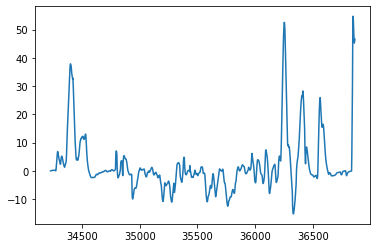

In [205]:
spk_beh_df_all.loc[ani,sess].query('task_index==0&trial==19')['v'].plot()

In [36]:
# sns.set_context('poster')

/tmp/ipykernel_374785/3535800653.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  X_raw = X_raw_all.loc[(ani,sess)]
/tmp/ipykernel_374785/3535800653.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  X_pwc = X_pwc_all.loc[(ani,sess)]
/tmp/ipykernel_374785/3535800653.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  changes_df = changes_df_all.loc[(ani,sess)]


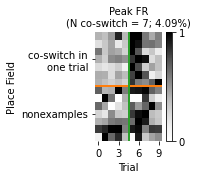

In [151]:
import change_point_post_analysis as cppa
reload(cppa)
X_raw = X_raw_all.loc[(ani,sess)]
X_pwc = X_pwc_all.loc[(ani,sess)]
changes_df = changes_df_all.loc[(ani,sess)]

fig,ax=cppa.show_coswitching_examples_nonexamples(X_raw.loc[task_ind],X_pwc.loc[task_ind], all_fields.loc[task_ind], changes_df.loc[task_ind], trial_index,onoff=onoff,fig=None,axs=None,all_field_selected_coms=None,field_coms=None,nonfield_coms_selected=None,do_sort=True,lw = 2,ticklabelfontsize = 10)
fn = f'X_raw_pwc_{onoff_str}_{sess}_task_{task_ind}_trialtype_{tt}_index_within_{index_within}'

ph.save_given_name(fig,fn,figdir)

# for fmt in ['png','svg']:
#     fn = f'X_raw_pwc_{onoff_str}_{sess}_task_{task_ind}_trialtype_{tt}_index_within_{index_within}.{fmt}'
#     fn_full = os.path.join(figdir,fn)
#     fig.savefig(fn_full,bbox_inches='tight')




In [142]:
n_co_sw_all.loc[ani,sess,task_ind,onoff,0,2]

344.0

In [141]:
n_co_sw_all.loc[ani,sess,task_ind,onoff,0,2]
n_co_sw_shuffle_all.loc[ani,sess,task_ind,onoff,0,2]

0      362.0
1      371.0
2      384.0
3      365.0
4      325.0
       ...  
995    362.0
996    322.0
997    391.0
998    367.0
999    393.0
Name: (e15_13f1, e15_13f1_220117, 0, 1, 0, 2), Length: 1000, dtype: float64

In [79]:
reload(ph)

<module 'plot_helper' from '/mnt/home/szheng/projects/util_code/plot_helper.py'>

/tmp/ipykernel_374785/3324314302.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  co_sw_pval_all.loc[ani,sess,task_ind,onoff].loc[n_trial_lag,n_in_tuple]


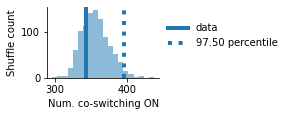

In [143]:

# onoff_str_d = {1:'ON',-1:'OFF'}
n_trial_lag=0
# for n_in_tuple in [2,3]:
for n_in_tuple in [2]:
#     onoff_str = onoff_str_d[onoff]
    co_sw_pval_all.loc[ani,sess,task_ind,onoff].loc[n_trial_lag,n_in_tuple]
    data_n=n_co_sw_all.loc[ani,sess,task_ind,onoff,n_trial_lag,n_in_tuple]
    shuffle_n=n_co_sw_shuffle_all.loc[ani,sess,task_ind,onoff,n_trial_lag,n_in_tuple]
    fig,ax=ph.plot_shuffle_data_dist_with_thresh(shuffle_n,data_n)
    sns.despine()
#     ax.set(xlabel=f'Num. co-switching {onoff_str}',title=f'{n_in_tuple}-tuple',ylabel='Shuffle count')
    ax.set(xlabel=f'Num. co-switching {onoff_str}',ylabel='Shuffle count')
    ax.legend(bbox_to_anchor=[1.,0.9],frameon=False)
    fn = f'n_co_sw_{onoff_str}_{n_in_tuple}_tuple_vs_shuffle_{sess}_task_{task_ind}'
#     ph.save_given_name(fig,fn,figdir)
    
    
    

/tmp/ipykernel_69033/1338633787.py:11: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_df = fr_map_trial_df_all.loc[ani,sess]
/tmp/ipykernel_69033/1338633787.py:12: PerformanceWarning: indexing past lexsort depth may impact performance.
  changes_df = changes_df_all.loc[ani,sess]
/tmp/ipykernel_69033/1338633787.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_fields = all_fields_recombined_all.loc[ani,sess]
/tmp/ipykernel_69033/1338633787.py:14: PerformanceWarning: indexing past lexsort depth may impact performance.
  spk_beh_df = spk_beh_df_all.loc[ani,sess]


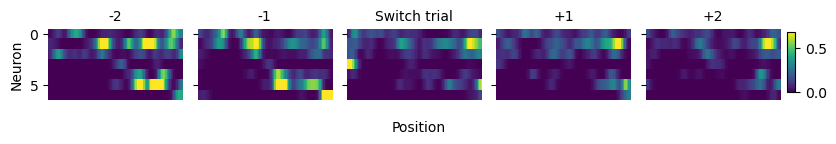

In [98]:
reload(prs)
sess='e15_13f1_220118'
ani='_'.join(sess.split('_')[:2])
onoff=-1
trial_index = 5
task_ind=0

onoff_str_d = {1:'ON',-1:'OFF'}
onoff_str = onoff_str_d[onoff]

fr_map_trial_df = fr_map_trial_df_all.loc[ani,sess]
changes_df = changes_df_all.loc[ani,sess]
all_fields = all_fields_recombined_all.loc[ani,sess]
spk_beh_df = spk_beh_df_all.loc[ani,sess]
trial_index_to_index_within_df=dpp.trial_index_to_index_within_trialtype(spk_beh_df)
index_within_to_trial_index_df = dpp.index_within_to_trial_index(spk_beh_df)


fig,axs, uid_field_l_sorted,tt,index_within = prs.plot_sequence_around_switch(trial_index,fr_map_trial_df,changes_df,all_fields,
                                trial_index_to_index_within_df,
                                task_ind=task_ind,onoff=onoff,
                                norm_fr_map_per_neuron=True,n_tr_to_show=5,fig=None,axs=None)
fn = f'sequence_switch_{sess}_task_{task_ind}_trialtype_{int(tt)}_index_within_{index_within}_onoff_{onoff}'
ph.save_given_name(fig,fn,figdir)


/tmp/ipykernel_69033/2188422003.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  X_raw = X_raw_all.loc[(ani,sess)]
/tmp/ipykernel_69033/2188422003.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  X_pwc = X_pwc_all.loc[(ani,sess)]
/tmp/ipykernel_69033/2188422003.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  changes_df = changes_df_all.loc[(ani,sess)]


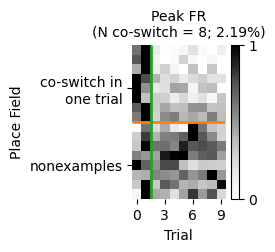

In [91]:
import change_point_post_analysis as cppa
reload(cppa)
X_raw = X_raw_all.loc[(ani,sess)]
X_pwc = X_pwc_all.loc[(ani,sess)]
changes_df = changes_df_all.loc[(ani,sess)]

fig,ax=cppa.show_coswitching_examples_nonexamples(X_raw.loc[task_ind],X_pwc.loc[task_ind], all_fields.loc[task_ind], changes_df.loc[task_ind], trial_index,onoff=onoff,fig=None,axs=None,all_field_selected_coms=None,field_coms=None,nonfield_coms_selected=None,do_sort=True,lw = 2,ticklabelfontsize = 10)
fn = f'X_raw_pwc_{onoff_str}_{sess}_task_{task_ind}_trialtype_{tt}_index_within_{index_within}'
ph.save_given_name(fig,fn,figdir)

# for fmt in ['png','svg']:
#     fn_full = os.path.join(figdir,fn)
#     fig.savefig(fn_full,bbox_inches='tight')




/tmp/ipykernel_69033/3597974346.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  co_sw_pval_all.loc[ani,sess,task_ind,onoff].loc[n_trial_lag,n_in_tuple]


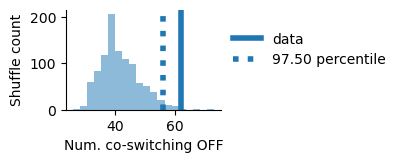

In [92]:

# onoff_str_d = {1:'ON',-1:'OFF'}
n_trial_lag=0
# for n_in_tuple in [2,3]:
for n_in_tuple in [2]:
#     onoff_str = onoff_str_d[onoff]
    co_sw_pval_all.loc[ani,sess,task_ind,onoff].loc[n_trial_lag,n_in_tuple]
    data_n=n_co_sw_all.loc[ani,sess,task_ind,onoff,n_trial_lag,n_in_tuple]
    shuffle_n=n_co_sw_shuffle_all.loc[ani,sess,task_ind,onoff,n_trial_lag,n_in_tuple]
    fig,ax=ph.plot_shuffle_data_dist_with_thresh(shuffle_n,data_n)
    sns.despine()
#     ax.set(xlabel=f'Num. co-switching {onoff_str}',title=f'{n_in_tuple}-tuple',ylabel='Shuffle count')
    ax.set(xlabel=f'Num. co-switching {onoff_str}',ylabel='Shuffle count')
    ax.legend(bbox_to_anchor=[1.,0.9],frameon=False)
    fn = f'n_co_sw_{onoff_str}_{n_in_tuple}_tuple_vs_shuffle_{sess}_task_{task_ind}'
    ph.save_given_name(fig,fn,figdir)

    

### X pwc and raw

/tmp/ipykernel_675728/1874874015.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  X_raw = X_raw_all.loc[(ani,sess)]
/tmp/ipykernel_675728/1874874015.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  X_pwc = X_pwc_all.loc[(ani,sess)]
/tmp/ipykernel_675728/1874874015.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  changes_df = changes_df_all.loc[(ani,sess)]


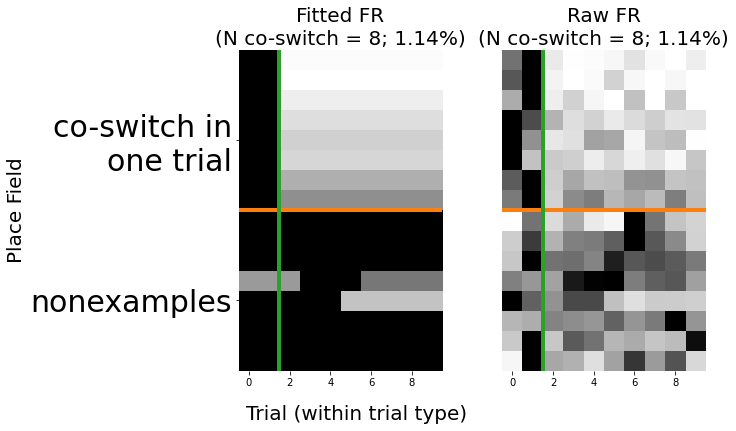

In [534]:
import change_point_post_analysis as cppa
reload(cppa)
X_raw = X_raw_all.loc[(ani,sess)]
X_pwc = X_pwc_all.loc[(ani,sess)]
changes_df = changes_df_all.loc[(ani,sess)]

fig,ax=cppa.show_coswitching_examples_nonexamples(X_raw.loc[task_ind],X_pwc.loc[task_ind], all_fields.loc[task_ind], changes_df.loc[task_ind], trial_index,onoff=onoff,fig=None,axs=None,all_field_selected_coms=None,field_coms=None,nonfield_coms_selected=None,do_sort=True,lw = 4,ticklabelfontsize = 30)

for fmt in ['png','svg']:
    fn = f'X_raw_pwc_{onoff_str}_{sess}_task_{task_ind}_trialtype_{tt}_index_within_{index_within}.{fmt}'
    fn_full = os.path.join(figdir,fn)
    fig.savefig(fn_full,bbox_inches='tight')




### pval relative to shuffle, one session

/tmp/ipykernel_675728/1063566049.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  co_sw_pval_all.loc[ani,sess,task_ind,onoff].loc[n_trial_lag,n_in_tuple]


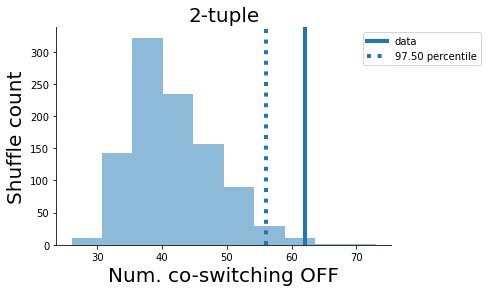

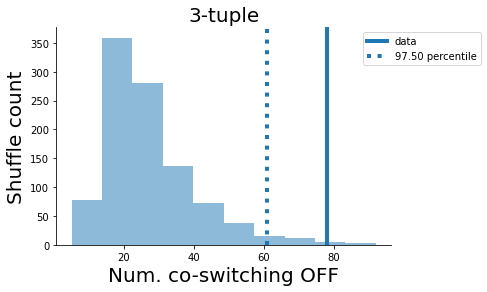

In [535]:

# onoff_str_d = {1:'ON',-1:'OFF'}
n_trial_lag=0
for n_in_tuple in [2,3]:
#     onoff_str = onoff_str_d[onoff]
    co_sw_pval_all.loc[ani,sess,task_ind,onoff].loc[n_trial_lag,n_in_tuple]
    data_n=n_co_sw_all.loc[ani,sess,task_ind,onoff,n_trial_lag,n_in_tuple]
    shuffle_n=n_co_sw_shuffle_all.loc[ani,sess,task_ind,onoff,n_trial_lag,n_in_tuple]
    fig,ax=ph.plot_shuffle_data_dist_with_thresh(shuffle_n,data_n)
    sns.despine()
    ax.set(xlabel=f'Num. co-switching {onoff_str}',title=f'{n_in_tuple}-tuple',ylabel='Shuffle count')
    ax.legend(bbox_to_anchor=[0.9,1])
    
    for fmt in ['png','svg']:
        fn = f'n_co_sw_{onoff_str}_{n_in_tuple}_tuple_vs_shuffle_{sess}_task_{task_ind}.{fmt}'
        fn_full = os.path.join(figdir,fn)
        fig.savefig(fn_full,bbox_inches='tight')
    
    
    

### ratemaps and shuffle

/mnt/home/szheng/ceph/place_variability/fig/paper/figure_cosw/cosw_OFF_ratemap_ex_e15_13f1_220118_task_0_trialtype_1_index_within_2 made!


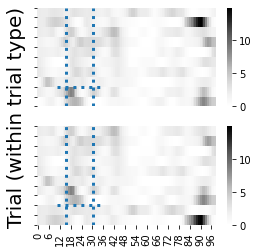

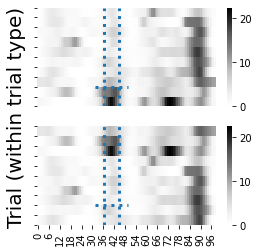

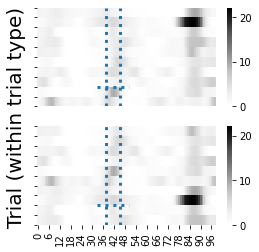

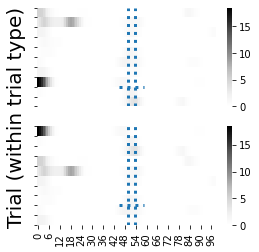

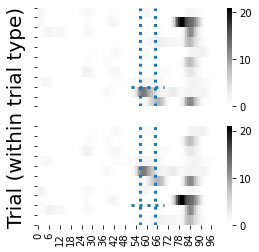

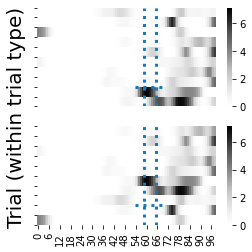

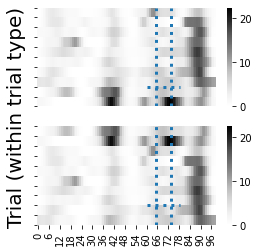

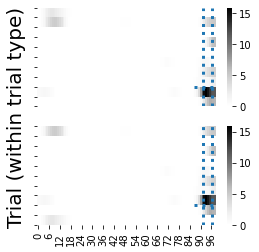

In [536]:
import plot_all_fr_map_x_pwc_one_session as plot_fm
reload(plot_fm)
task_ind = task_ind
tt=tt
# nplots = len(uid_l_sorted)
# fig,axs=plt.subplots(1,nplots,figsize=(4*nplots,2))


subdir = f'cosw_{onoff_str}_ratemap_ex_{sess}_task_{task_ind}_trialtype_{tt}_index_within_{index_within}'
subdir = misc.get_or_create_subdir(figdir,subdir)

uid_l_sorted = uid_field_l_sorted.get_level_values(1)
for ii,uid_field in enumerate(uid_field_l_sorted):
#     ax=axs.ravel()[ii]
    fig,axs=plt.subplots(2,1,figsize=(4,4))
    uid = uid_l_sorted[ii]
    field_id=uid_field_l_sorted[ii][-1]
    all_fields_sub=all_fields.loc[[(task_ind,*uid_field)]]
    ax=axs[0]
    plot_fm.plot_ratemap_one_neuron_all_fields_using_changes_df(fr_map_trial_df,all_fields_sub,changes_df,index_within_to_trial_index_df,
                                           task_ind,tt,uid,flipy=True,
                                           fig=fig,ax=ax
                                          )
    ax.set(ylabel="",xlabel="",xticks=[])
    ax=axs[1]
    plot_fm.plot_ratemap_one_neuron_all_fields_using_changes_df(fr_map_trial_df,all_fields_sub,changes_df,index_within_to_trial_index_df,
                                           task_ind,tt,uid,flipy=True,
                                           fig=fig,ax=ax,shuffle_ratemap=True
                                          )
    ax.set(ylabel="",xlabel="")
    fig.supylabel('Trial (within trial type)',fontsize=20)
    
    for fmt in ['png','svg']:
        fn=f'{uid}_{field_id}.{fmt}'
        fn_full = os.path.join(subdir,fn)
        fig.savefig(fn_full,bbox_inches='tight')
    

In [447]:
ma=(changes_df.loc[task_ind,trial_index]==-1)
changes_df.loc[task_ind,trial_index].loc[ma]

1.0  59   0   -1.0
          1   -1.0
     74   0   -1.0
     89   1   -1.0
     127  2   -1.0
     210  0   -1.0
     241  1   -1.0
     334  0   -1.0
Name: 5, dtype: float64

In [407]:
ddf=db.loc[db['sess_name']==sess]['data_dir_full'].values[0]
frmap_null_fn=os.path.join(ddf,'py_data','frmap_null_afterheadscan.p')
frmap_null = pickle.load(open(frmap_null_fn,'rb'))

<Axes: >

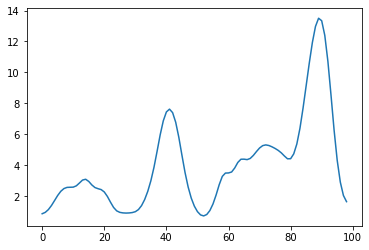

In [426]:
uid=59
fr_map_trial_df.loc[task_ind,tt,uid].dropna(axis=1).mean(axis=1).plot()

In [429]:
all_fields.loc[task_ind,tt,uid]

,start,end,com,peak,fr_peak,fr_mean,other_field_index
field_index,,,,,,,
0,37,45,40,41,6.729695,5.478063,NaN
1,66,74,69,69,4.714903,4.466068,NaN
3,81,94,88,89,13.682923,9.5303,NaN


<Axes: >

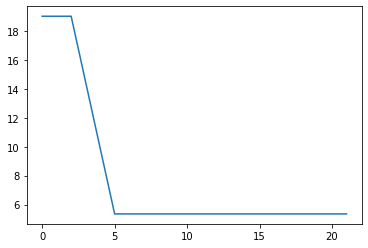

In [441]:
X_pwc.loc[(task_ind,tt,uid),:].loc[0].dropna().plot()

<Axes: xlabel='lin_binned'>

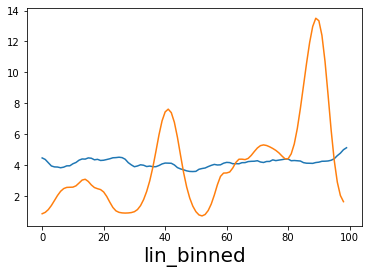

In [427]:
frmap_null[task_ind,tt].loc[(slice(None),uid),:].quantile(0.95,axis=0).plot()
fr_map_trial_df.loc[task_ind,tt,uid].dropna(axis=1).mean(axis=1).plot()

In [396]:
uid_field_l_sorted

MultiIndex([(1.0,  89, 1),
            (1.0,  59, 0),
            (1.0,  74, 0),
            (1.0, 127, 2),
            (1.0, 210, 0),
            (1.0, 334, 0),
            (1.0,  59, 1),
            (1.0, 241, 1)],
           names=[None, None, 'field_index'])

In [399]:
all_fields.loc[task_ind].loc[uid_field_l_sorted[-2]]

start                      66
end                        74
com                        69
peak                       69
fr_peak              4.714903
fr_mean              4.466068
other_field_index         NaN
Name: (1.0, 59, 1), dtype: object

<Axes: >

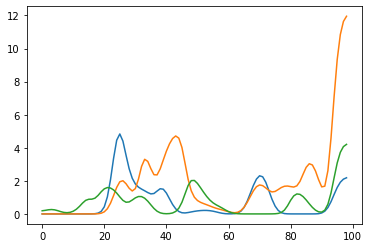

In [230]:
uid=98
fr_map_trial_df.loc[(task_ind,tt,uid),index_within-1].plot()
fr_map_trial_df.loc[(task_ind,tt,uid),index_within].plot()
fr_map_trial_df.loc[(task_ind,tt,uid),index_within+1].plot()

/tmp/ipykernel_675728/740337262.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  plt.plot(X_raw_all.loc[ani,sess,task_ind,tt,uid].dropna(axis=1).T.values,marker='o')
/tmp/ipykernel_675728/740337262.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  plt.plot(X_pwc_all.loc[ani,sess,task_ind,tt,uid].dropna(axis=1).T.values)


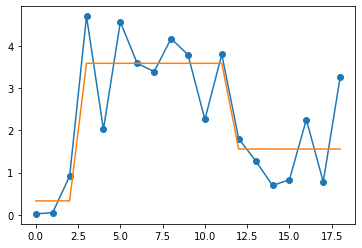

In [226]:
uid=98
plt.plot(X_raw_all.loc[ani,sess,task_ind,tt,uid].dropna(axis=1).T.values,marker='o')
plt.plot(X_pwc_all.loc[ani,sess,task_ind,tt,uid].dropna(axis=1).T.values)


<Axes: >

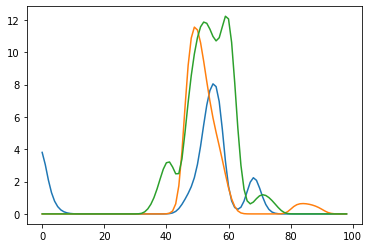

In [153]:
fr_map_trial_df.loc[(task_ind,tt,uid),index_within-1].plot()
fr_map_trial_df.loc[(task_ind,tt,uid),index_within].plot()
fr_map_trial_df.loc[(task_ind,tt,uid),index_within+1].plot()


<Axes: >

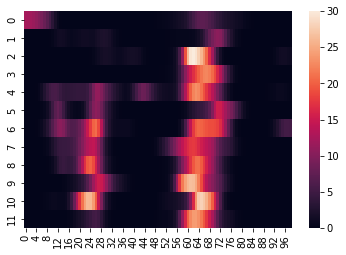

In [75]:
sns.heatmap(fr_map_trial_df.loc[order[12],:].dropna(axis=1,how='all').T)

# within field rate over trial, with switch marked

In [295]:
X_pwc.loc[task_ind].loc[uid_field_l_sorted].dropna(axis=1)

0          2         5         8         11        13  \
1.0 89  1   7.341624   7.341624  3.422961  3.422961  3.422961  3.422961   
    59  0  19.024725  19.024725  5.353492  5.353492  5.353492  5.353492   
    74  0   7.598816   7.598816  4.242123  4.242123  4.242123  4.242123   
    127 2   2.795081   2.795081  0.960786  0.960786  0.960786  0.960786   
    210 0  10.344758  10.344758  1.014163  1.014163  1.014163  1.014163   
    334 0   6.162070   6.162070  0.492077  0.492077  0.492077  0.492077   
    59  1  15.152920  15.152920  4.870494  4.870494  4.870494  4.870494   
    241 1  11.337798  11.337798  2.316120  2.316120  2.316120  2.316120   

                 15        17        19        21  
1.0 89  1  3.422961  3.422961  3.422961  3.422961  
    59  0  5.353492  5.353492  5.353492  5.353492  
    74  0  4.242123  4.242123  4.242123  4.242123  
    127 2  0.960786  0.960786  0.960786  0.960786  
    210 0  1.014163  1.014163  1.014163  1.014163  
    334 0  0.492077  0.492077  0.492077  0.492077  
    59  1  4.870494  4.870494  4.870494  4.870494  
    241 1  2.316120  2.316120  2.316120  2.316120

(<Figure size 720x432 with 2 Axes>,
 array([<Axes: title={'center': 'Fitted FR\n(N co-switch = 6; 0.85%)'}, ylabel='Place Field'>,
        <Axes: title={'center': 'Raw FR\n(N co-switch = 6; 0.85%)'}>],
       dtype=object))

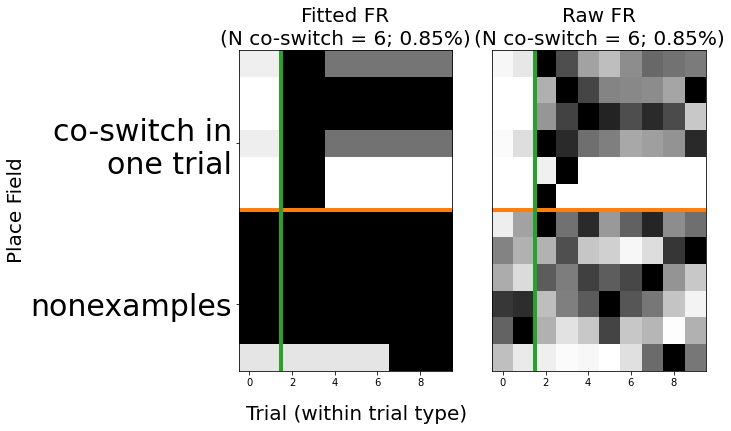

/tmp/ipykernel_675728/815027518.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  X_raw = X_raw_all.loc[(ani,sess)]
/tmp/ipykernel_675728/815027518.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  X_pwc = X_pwc_all.loc[(ani,sess)]
/tmp/ipykernel_675728/815027518.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  changes_df = changes_df_all.loc[(ani,sess)]


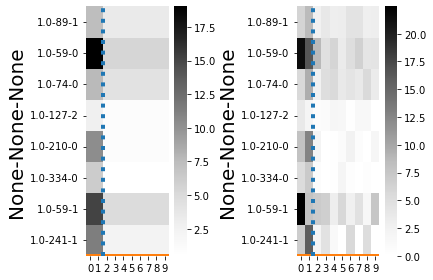

In [297]:
reload(prs)


tt,index_within,index_within_within,uid_l_sorted,uid_field_l_sorted = prs.get_coswitching_field_one_trial(trial_index,changes_df,all_fields,trial_index_to_index_within_df,
                                    task_ind=task_ind,onoff=onoff)

lw=4
seperating_line = len(uid_field_l_sorted)

data_pwc = X_pwc.loc[task_ind].loc[uid_field_l_sorted].dropna(axis=1).T.reset_index(drop=True).T
data_raw = X_raw.loc[task_ind].loc[uid_field_l_sorted].dropna(axis=1).T.reset_index(drop=True).T
axs=None
if axs is None:
    fig,axs=plt.subplots(1,2,sharey=False)
sns.heatmap(data_pwc,ax=axs[0],cmap='Greys')
axs[0].hlines(seperating_line,*axs[0].get_xlim(),linewidth=lw,color='C1')
axs[0].vlines(index_within_within,*axs[0].get_ylim(),linewidth=lw,linestyle=':',color='C0')
# yticks = [int(len(field_coms)/2),len(field_coms)+int(len(nonfield_coms_selected)/2)]
# axs[0].set(ylabel="Place Field",yticks=yticks,yticklabels=['co-switch in\none trial','nonexamples'],xlabel="Trial",title=f"Fitted FR\n(N co-switch = {len(field_coms)})")
sns.heatmap(data_raw,ax=axs[1],cmap='Greys')
axs[1].hlines(seperating_line,*axs[1].get_xlim(),linewidth=lw,color='C1')
axs[1].vlines(index_within_within,*axs[0].get_ylim(),linewidth=lw,linestyle=':',color='C0')
# axs[1].set(ylabel="",yticks=[],title=f"Raw FR\n(N co-switch = {len(field_coms)})",xlabel="Trial")
# axs[2].invert_yaxis()
# axs[2].plot(all_field_selected_coms,np.arange(len(all_field_selected_coms)),marker='o',c='k')
# axs[2].set(ylabel="",yticks=[],xlabel="COM (bin)",title='Location',xticks=[0,25,50,75,100])
# axs[2].hlines(seperating_line,*axs[2].get_xlim(),linewidth=lw,color='C1')
plt.tight_layout()



# fig,_ = cppa.show_coswitching_examples_nonexamples(X_raw,X_pwc,all_fields,changes_df,trial_index,onoff=onoff,
#                                                                      all_field_selected_coms=all_field_selected_coms,field_coms=field_coms,nonfield_coms_selected=nonfield_coms_selected,
#                                                                      fig=fig,axs=axs_sub,do_sort=do_sort,lw=lw,
#                                                                    ticklabelfontsize = ticklabelfontsize
#                                                                     )

In [274]:
uid_field_l_sorted

MultiIndex([(1.0,  89, 1),
            (1.0,  59, 0),
            (1.0,  74, 0),
            (1.0, 127, 2),
            (1.0, 210, 0),
            (1.0, 334, 0),
            (1.0,  59, 1),
            (1.0, 241, 1)],
           names=[None, None, 'field_index'])

In [276]:
changes_df

0    1    2    3    4    5    6    7    8    9   ...  60  61  \
0 0.0 39  0  NaN  0.0  NaN  0.0  0.0  NaN  0.0  0.0  NaN  0.0  ... NaN NaN   
          1  NaN  0.0  NaN  0.0  0.0  NaN  0.0  0.0  NaN  0.0  ... NaN NaN   
          2  NaN  0.0  NaN  0.0  0.0  NaN  0.0  0.0  NaN  0.0  ... NaN NaN   
          3  NaN  0.0  NaN  0.0  0.0  NaN  0.0  0.0  NaN  0.0  ... NaN NaN   
      40  2  NaN  0.0  NaN  0.0  0.0  NaN  0.0  0.0  NaN  0.0  ... NaN NaN   
...          ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ..  ..   
1 1.0 352 0  0.0  0.0  0.0  0.0  1.0  0.0  0.0 -1.0  0.0  0.0  ... NaN NaN   
      353 0  0.0  0.0  0.0  1.0  0.0  0.0 -1.0  0.0  0.0  0.0  ... NaN NaN   
      354 0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ... NaN NaN   
      356 0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... NaN NaN   
      358 0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... NaN NaN   

             62  63  64  65  66  67  68  69  
0 0.0 39  0 NaN NaN NaN NaN NaN NaN NaN NaN  
          1 NaN NaN NaN NaN NaN NaN NaN NaN  
          2 NaN NaN NaN NaN NaN NaN NaN NaN  
          3 NaN NaN NaN NaN NaN NaN NaN NaN  
      40  2 NaN NaN NaN NaN NaN NaN NaN NaN  
...          ..  ..  ..  ..  ..  ..  ..  ..  
1 1.0 352 0 NaN NaN NaN NaN NaN NaN NaN NaN  
      353 0 NaN NaN NaN NaN NaN NaN NaN NaN  
      354 0 NaN NaN NaN NaN NaN NaN NaN NaN  
      356 0 NaN NaN NaN NaN NaN NaN NaN NaN  
      358 0 NaN NaN NaN NaN NaN NaN NaN NaN  

[1085 rows x 70 columns]

0          2         5         8         11        13  \
1.0 89  1   6.095235   8.588012  2.570667  3.799036  3.027523  3.168484   
    59  0  21.556729  16.492720  8.694704  4.744549  5.983573  3.437613   
    74  0   5.699325   9.498306  2.650493  5.083321  5.590980  3.746638   
    127 2   3.681498   1.908664  0.631247  0.780574  1.683245  1.628024   
    210 0   7.962376  12.727141  2.025403  0.109572  0.263346  0.863129   
    334 0   5.197737   7.126403  0.678301  0.001235  0.280072  1.986688   
    59  1  22.460744   7.845096  7.059273  6.634869  3.089922  5.784803   
    241 1   6.810226  15.865369  2.138025  4.499148  1.128258  0.000000   

                 15        17        19        21  
1.0 89  1  4.391372  4.434526  2.926816  3.065266  
    59  0  5.087128  6.424282  4.207020  4.249069  
    74  0  4.212383  3.629189  5.556207  3.467773  
    127 2  0.312997  1.251715  1.369004  0.029486  
    210 0  2.508697  0.605011  0.000000  1.738149  
    334 0  0.495513  0.000000  0.494073  0.000734  
    59  1  2.837359  4.668005  1.418864  7.470852  
    241 1  5.657938  0.000000  5.105592  0.000000

In [252]:
changes_df

0    1    2    3    4    5    6    7    8    9   ...  60  61  62  \
0.0  39  0  NaN  0.0  NaN  0.0  0.0  NaN  0.0  0.0  NaN  0.0  ... NaN NaN NaN   
         1  NaN  0.0  NaN  0.0  0.0  NaN  0.0  0.0  NaN  0.0  ... NaN NaN NaN   
         2  NaN  0.0  NaN  0.0  0.0  NaN  0.0  0.0  NaN  0.0  ... NaN NaN NaN   
         3  NaN  0.0  NaN  0.0  0.0  NaN  0.0  0.0  NaN  0.0  ... NaN NaN NaN   
     40  2  NaN  0.0  NaN  0.0  0.0  NaN  0.0  0.0  NaN  0.0  ... NaN NaN NaN   
...         ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ..  ..  ..   
both 342 0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... NaN NaN NaN   
     347 0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... NaN NaN NaN   
     348 0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... NaN NaN NaN   
     353 0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... NaN NaN NaN   
     356 0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... NaN NaN NaN   

            63  64  65  66  67  68  69  
0.0  39  0 NaN NaN NaN NaN NaN NaN NaN  
         1 NaN NaN NaN NaN NaN NaN NaN  
         2 NaN NaN NaN NaN NaN NaN NaN  
         3 NaN NaN NaN NaN NaN NaN NaN  
     40  2 NaN NaN NaN NaN NaN NaN NaN  
...         ..  ..  ..  ..  ..  ..  ..  
both 342 0 NaN NaN NaN NaN NaN NaN NaN  
     347 0 NaN NaN NaN NaN NaN NaN NaN  
     348 0 NaN NaN NaN NaN NaN NaN NaN  
     353 0 NaN NaN NaN NaN NaN NaN NaN  
     356 0 NaN NaN NaN NaN NaN NaN NaN  

[703 rows x 70 columns]

# figure out how to do one session

In [5]:
import pairwise_analysis as pwa
reload(pwa)
import switch_metrics as sm
reload(sm)
import test_co_switch as tcs
reload(tcs)
import shuffle_changes_df_one_session as scdos

In [27]:
row = subdb.iloc[2]
task_index=0
data_dir_full=ddf = row['data_dir_full']
ani=row['animal_name.1']
sess = row['sess_name']
# ani,sess,task_index = 'e13_26m1','e13_26m1_210913',0
changes_df_one = changes_df_all.loc[ani,sess,task_index]
all_sw_d_one = all_sw_d_all.loc[ani,sess,task_index]
pf_params_recombined_one=pf_params_recombined_all.loc[ani,sess]
# changes_df_one = changes_df_all.loc[ani,sess]
spk_beh_df = spk_beh_df_all.loc[ani,sess]

shuffle_all_sw_one=scdos.main(ddf,test_mode=False,dosave=False,force_reload=False,load_only=True)

/tmp/ipykernel_1028765/3740543830.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  changes_df_one = changes_df_all.loc[ani,sess,task_index]
/tmp/ipykernel_1028765/3740543830.py:8: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_sw_d_one = all_sw_d_all.loc[ani,sess,task_index]
/tmp/ipykernel_1028765/3740543830.py:9: PerformanceWarning: indexing past lexsort depth may impact performance.
  pf_params_recombined_one=pf_params_recombined_all.loc[ani,sess]
/tmp/ipykernel_1028765/3740543830.py:11: PerformanceWarning: indexing past lexsort depth may impact performance.
  spk_beh_df = spk_beh_df_all.loc[ani,sess]


/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220118/py_data/shuffle_all_sw_afterheadscan.p exists; loading---


In [24]:
reload(sdos)
reload(tcs)
reload(scdos)


/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/shuffle_all_sw_afterheadscan.p exists; loading---


In [17]:
import change_point_analysis_central_arm_seperate as cpacas
reload(cpacas)

<module 'change_point_analysis_central_arm_seperate' from '/mnt/home/szheng/projects/nmf_analysis/change_point_analysis_central_arm_seperate.py'>

In [19]:
all_sw_sub

trialtype  uid  field_index         time  speed_gauss  field_pos  \
0 1         1.0   57            0  7961.019867    15.260724        0.0   
  2         1.0  191            1  7968.538433    13.291081       48.0   
  4         1.0  202            1  7967.271433    26.916181       36.0   
  6         1.0  335            1  7966.454567    36.737558       21.0   
  7         1.0  436            0  7967.154733    29.594099       34.0   
...         ...  ...          ...          ...          ...        ...   
  426       1.0  276            1  9909.295283     3.149394       87.0   
  428      both  299            0  9892.291000    24.913817       21.0   
  429       1.0   40            2  9938.936100    11.170711       91.0   
  433       1.0  247            0  9930.850733     4.964605       54.0   
  434       1.0  262            2  9938.819400    12.491046       90.0   

       trial_index  switch  index_within  switch_trial  switch_trial_frac  \
0 1              4     1.0             2           2.0           0.054054   
  2              4     1.0             2           2.0           0.054054   
  4              4     1.0             2           2.0           0.054054   
  6              4     1.0             2           2.0           0.054054   
  7              4     1.0             2           2.0           0.054054   
...            ...     ...           ...           ...                ...   
  426           66     1.0            34          34.0           0.918919   
  428           66     1.0            34          66.0           0.942857   
  429           67     1.0            35          35.0           0.945946   
  433           67     1.0            35          35.0           0.945946   
  434           67     1.0            35          35.0           0.945946   

       pre_ntrials_in_segment  post_ntrials_in_segment  
0 1                         2                       35  
  2                         2                        3  
  4                         2                        4  
  6                         2                       35  
  7                         2                       35  
...                       ...                      ...  
  426                      23                        3  
  428                      66                        4  
  429                      35                        2  
  433                      35                        2  
  434                      31                        2  

[230 rows x 13 columns]

In [46]:
# all_sw_d_one_manip= all_sw_d_one.loc[(all_sw_d_one['trialtype'] ==0)|(all_sw_d_one['trialtype'] =='both')]

# shuffle_all_sw_one_manip = [aa.loc[(aa['trialtype']==0)|(aa['trialtype']=='both')] for aa in shuffle_all_sw_one]
                            
                            

In [8]:

changes_df_shuffle = tcs.gen_circular_shuffle_trialtype_seperated(changes_df_one,nrepeats=200,min_cpd_win=2)

In [104]:
mat = pd.DataFrame(np.array([[1,0,1,0,1],[1,1,0,1,0],[0,1,1,0,1],[0,0,0,1,0]]))

In [152]:
import copy
# with sliding window
# window_l=[0,1,2]
# n_co=2
# onoff=1
# changes_df = mat
def get_n_pair_per_trial_sliding_window(changes_df,window_l=[0,1,2],
                                            n_co=2,
                                            onoff=1):
    '''
    window_l: trial lag to consider co pop up
    
    add up the within windows, subtract the lower order count on the overlapping part
    e.g. suppose we define coswitch to be within 2 trials. Trial 1,2 are grouped, 2,3 are grouped, then counting pairs
    within both and sum them would lead to double counting the pairs in trial 2, and need to subtract.
    k: how many in pair to count
    '''
    n_pair_per_trial_d = {}
    n_pair_per_trial_pre_subtract_d={} # before subtracting lower order, need this to be subtracted from the higher order
    n_pair_d = {}
    prev_win = 0
    changes_df = changes_df.dropna(axis=1,how='all')
    changes_int = (changes_df==onoff).astype(int)
    ntrials = changes_df.shape[1]
    for win in window_l:
        if win==0:
            n_sw_per_trial = changes_int.sum(axis=0)
            n_pair_per_trial=scipy.special.comb(n_sw_per_trial,n_co)
            n_pair_per_trial_d[win] = n_pair_per_trial
            n_pair_per_trial_pre_subtract_d[win] = n_pair_per_trial
        else:

            n_sw_per_trial = changes_int.rolling(win+1,axis=1).sum().sum(axis=0)
            n_pair_per_trial=scipy.special.comb(n_sw_per_trial,n_co)
            n_pair_per_trial_pre_subtract_d[win] = copy.copy(n_pair_per_trial)
            n_pair_per_trial[win:-1] = n_pair_per_trial[win:-1] - n_pair_per_trial_pre_subtract_d[prev_win][win:-1] # the overlap indices are from win to the second to last one
            n_pair_per_trial_d[win] = n_pair_per_trial
        n_pair_d[win] = n_pair_per_trial.sum()
        prev_win = win
    
    return n_pair_d,n_pair_per_trial_d,n_pair_per_trial_pre_subtract_d

def get_n_pair_per_trial_sweep(changes_df,window_l=[0,1,2],n_co_l=[2,3,4]):
    '''
    sweeping on off, also the number within tuple
    '''
    n_pair_all_n_co_d={}
    for n_co in n_co_l:
        n_pair_per_n_co = {}
        for onoff in [1,-1]:
            n_pair_d,_,_ = get_n_pair_per_trial_sliding_window(changes_df,window_l=window_l,
                                            n_co=n_co,
                                            onoff=onoff)
            n_pair_per_n_co[onoff] = pd.Series(n_pair_d)
        n_pair_all_n_co_d[n_co] = pd.concat(n_pair_per_n_co)
    n_pair_all_n_co_d = pd.DataFrame(n_pair_all_n_co_d)
    n_pair_all_n_co_d=n_pair_all_n_co_d.stack()
    n_pair_all_n_co_d.index.names=['onoff','n_trial_lag','n_in_tuple']

    return n_pair_all_n_co_d




In [207]:
def test_co_switch(changes_df,changes_df_shuffle=None,window_l=[0,1,2],n_co_l=[2,3,4]):
    n_pair_all_n_co_d=get_n_pair_per_trial_sweep(changes_df,window_l=[0,1,2],n_co_l=[2,3,4])
    
    n_pair_all_n_co_d_l = []
    for cd_sh in changes_df_shuffle:
        n_pair_all_n_co_d_sh = get_n_pair_per_trial_sweep(cd_sh,window_l=[0,1,2],n_co_l=[2,3,4])
        n_pair_all_n_co_d_l.append(n_pair_all_n_co_d_sh)
    n_pair_all_n_co_d_l = pd.concat(n_pair_all_n_co_d_l,axis=1)
    pval=(n_pair_all_n_co_d_l>n_pair_all_n_co_d.values[:,None]).mean(axis=1) 
    return pval,n_pair_all_n_co_d,n_pair_all_n_co_d_l
    

In [220]:

reload(tcs)

changes_df_all_task = changes_df_all.loc[ani,sess]
changes_df_shuffle_all_task = tcs.gen_circular_shuffle_trialtype_seperated(changes_df_all_task,2)
tcs.test_co_switch_all_task(changes_df_all_task,changes_df_shuffle_all_task=None,window_l=[0,1],n_co_l=[2,3],shuffle_kwargs={'nrepeats':2})






/tmp/ipykernel_1028765/2716143514.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  changes_df_all_task = changes_df_all.loc[ani,sess]


(   onoff  n_trial_lag  n_in_tuple
 0   1     0            2             0.0
                        3             0.0
                        4             0.0
           1            2             0.0
                        3             0.0
                        4             0.0
           2            2             1.0
                        3             0.0
                        4             0.0
    -1     0            2             0.0
                        3             0.0
                        4             0.0
           1            2             0.0
                        3             0.0
                        4             0.0
           2            2             1.0
                        3             0.0
                        4             0.0
 1   1     0            2             0.0
                        3             0.0
                        4             0.0
           1            2             0.0
                        3             0.0

In [224]:
import test_co_switch_one_sess as tcsos
reload(tcsos)

<module 'test_co_switch_one_sess' from '/mnt/home/szheng/projects/place_variability/code/test_co_switch_one_sess.py'>

In [225]:
tcsos.main(data_dir_full,test_mode=True)

/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220118/py_data/sw_res_afterheadscan.p exists; loading---


{'co_sw_pval':    onoff  n_trial_lag  n_in_tuple
 0   1     0            2             0.0
                        3             0.0
                        4             0.0
           1            2             0.0
                        3             0.0
                        4             0.0
           2            2             1.0
                        3             0.0
                        4             0.0
    -1     0            2             0.0
                        3             0.0
                        4             0.0
           1            2             0.0
                        3             0.0
                        4             0.0
           2            2             0.5
                        3             0.0
                        4             0.0
 1   1     0            2             0.0
                        3             0.0
                        4             0.0
           1            2             0.0
                        3  

In [169]:
changes_df = changes_df_one

In [170]:
n_pair_all_n_co_d=get_n_pair_per_trial_sweep(changes_df,window_l=[0,1,2],n_co_l=[2,3,4])

In [157]:
n_pair_all_n_co_d_l = []
for cd_sh in changes_df_shuffle:
    n_pair_all_n_co_d_sh = get_n_pair_per_trial_sweep(cd_sh,window_l=[0,1,2],n_co_l=[2,3,4])
    n_pair_all_n_co_d_l.append(n_pair_all_n_co_d_sh)
n_pair_all_n_co_d_l = pd.concat(n_pair_all_n_co_d_l,axis=1)

In [201]:
n_pair_all_n_co_d_l

0        1        2        3        4    \
onoff n_trial_lag n_in_tuple                                                
 1    0           2             304.0    262.0    265.0    252.0    266.0   
                  3             734.0    471.0    498.0    412.0    483.0   
                  4            1450.0    617.0    740.0    472.0    654.0   
      1           2             756.0    713.0    690.0    717.0    750.0   
                  3            3315.0   2753.0   2603.0   2774.0   3230.0   
                  4           10371.0   7180.0   6633.0   7196.0  10100.0   
      2           2            1236.0   1152.0   1092.0   1129.0   1192.0   
                  3            8705.0   7194.0   6360.0   6931.0   7977.0   
                  4           43154.0  30660.0  25093.0  29370.0  37591.0   
-1    0           2              37.0     49.0     46.0     45.0     35.0   
                  3              19.0     47.0     37.0     35.0     17.0   
                  4               6.0     37.0     21.0     20.0      6.0   
      1           2             124.0    113.0    137.0    125.0    126.0   
                  3             182.0    150.0    272.0    228.0    191.0   
                  4             163.0    124.0    379.0    278.0    185.0   
      2           2             201.0    197.0    220.0    194.0    203.0   
                  3             491.0    467.0    665.0    494.0    494.0   
                  4             735.0    688.0   1414.0    861.0    771.0   

                                  5        6        7        8        9    \
onoff n_trial_lag n_in_tuple                                                
 1    0           2             328.0    278.0    232.0    229.0    262.0   
                  3             955.0    577.0    325.0    316.0    440.0   
                  4            2457.0    998.0    300.0    278.0    500.0   
      1           2             744.0    762.0    681.0    671.0    772.0   
                  3            3355.0   3300.0   2376.0   2347.0   3268.0   
                  4           11456.0  10088.0   5354.0   5313.0   9315.0   
      2           2            1159.0   1236.0   1113.0   1060.0   1212.0   
                  3            7685.0   8620.0   6406.0   5801.0   7978.0   
                  4           36603.0  42303.0  24285.0  20868.0  35624.0   
-1    0           2              33.0     36.0     42.0     50.0     38.0   
                  3              12.0     14.0     21.0     43.0     17.0   
                  4               2.0      2.0      6.0     23.0      3.0   
      1           2             115.0    116.0    117.0    117.0    128.0   
                  3             142.0    152.0    175.0    188.0    208.0   
                  4              93.0    114.0    159.0    198.0    202.0   
      2           2             194.0    193.0    186.0    194.0    205.0   
                  3             451.0    448.0    400.0    501.0    560.0   
                  4             642.0    649.0    517.0    887.0   1008.0   

                              ...      190      191      192      193  \
onoff n_trial_lag n_in_tuple  ...                                       
 1    0           2           ...    271.0    250.0    242.0    250.0   
                  3           ...    511.0    434.0    399.0    429.0   
                  4           ...    687.0    544.0    518.0    515.0   
      1           2           ...    780.0    703.0    671.0    686.0   
                  3           ...   3472.0   2764.0   2401.0   2596.0   
                  4           ...  10623.0   7664.0   5789.0   6711.0   
      2           2           ...   1250.0   1090.0   1115.0   1121.0   
                  3           ...   8992.0   6271.0   6654.0   6691.0   
                  4           ...  44456.0  24141.0  27309.0  26771.0   
-1    0           2           ...     55.0     36.0     47.0     42.0   
                  3           ...     48.0     16.0     36.0     30.0   
   

In [205]:
pval=(n_pair_all_n_co_d_l>n_pair_all_n_co_d.values[:,None]).mean(axis=1) 

In [206]:
pval

onoff  n_trial_lag  n_in_tuple
 1     0            2             0.005
                    3             0.000
                    4             0.000
       1            2             0.045
                    3             0.000
                    4             0.000
       2            2             0.695
                    3             0.305
                    4             0.135
-1     0            2             0.010
                    3             0.010
                    4             0.010
       1            2             0.025
                    3             0.005
                    4             0.005
       2            2             0.500
                    3             0.115
                    4             0.025
dtype: float64

In [167]:
n_pair_all_n_co_d.to_frame() > 

0
onoff n_trial_lag n_in_tuple      
 1    0           2            5.0
                  3            0.0
                  4            0.0
      1           2           21.0
                  3           16.0
                  4            4.0
      2           2           33.0
                  3           52.0
                  4           43.0
-1    0           2            0.0
                  3            0.0
                  4            0.0
      1           2            0.0
                  3            0.0
                  4            0.0
      2           2            0.0
                  3            0.0
                  4            0.0

In [182]:
n_pair_all_n_co_d_l.loc[(1,slice(None),(2,3)),:]

0       1       2       3       4       5    \
onoff n_trial_lag n_in_tuple                                                   
1     0           2            304.0   262.0   265.0   252.0   266.0   328.0   
                  3            734.0   471.0   498.0   412.0   483.0   955.0   
      1           2            756.0   713.0   690.0   717.0   750.0   744.0   
                  3           3315.0  2753.0  2603.0  2774.0  3230.0  3355.0   
      2           2           1236.0  1152.0  1092.0  1129.0  1192.0  1159.0   
                  3           8705.0  7194.0  6360.0  6931.0  7977.0  7685.0   

                                 6       7       8       9    ...     190  \
onoff n_trial_lag n_in_tuple                                  ...           
1     0           2            278.0   232.0   229.0   262.0  ...   271.0   
                  3            577.0   325.0   316.0   440.0  ...   511.0   
      1           2            762.0   681.0   671.0   772.0  ...   780.0   
                  3           3300.0  2376.0  2347.0  3268.0  ...  3472.0   
      2           2           1236.0  1113.0  1060.0  1212.0  ...  1250.0   
                  3           8620.0  6406.0  5801.0  7978.0  ...  8992.0   

                                 191     192     193     194     195     196  \
onoff n_trial_lag n_in_tuple                                                   
1     0           2            250.0   242.0   250.0   269.0   261.0   260.0   
                  3            434.0   399.0   429.0   480.0   432.0   452.0   
      1           2            703.0   671.0   686.0   717.0   716.0   742.0   
                  3           2764.0  2401.0  2596.0  2854.0  2691.0  3030.0   
      2           2           1090.0  1115.0  1121.0  1175.0  1144.0  1166.0   
                  3           6271.0  6654.0  6691.0  7247.0  6968.0  7473.0   

                                 197     198     199  
onoff n_trial_lag n_in_tuple                          
1     0           2            268.0   281.0   241.0  
                  3            492.0   604.0   384.0  
      1           2            685.0   804.0   701.0  
                  3           2546.0  3805.0  2738.0  
      2           2           1106.0  1284.0  1100.0  
                  3           6536.0  9646.0  6663.0  

[6 rows x 200 columns]

In [184]:
n_pair_all_n_co_d_l.loc[comparisons,:]

0       1       2       3       4       5    \
onoff n_trial_lag n_in_tuple                                                   
1     0           2            304.0   262.0   265.0   252.0   266.0   328.0   
                  3            734.0   471.0   498.0   412.0   483.0   955.0   
      1           2            756.0   713.0   690.0   717.0   750.0   744.0   
                  3           3315.0  2753.0  2603.0  2774.0  3230.0  3355.0   
      2           2           1236.0  1152.0  1092.0  1129.0  1192.0  1159.0   
                  3           8705.0  7194.0  6360.0  6931.0  7977.0  7685.0   

                                 6       7       8       9    ...     190  \
onoff n_trial_lag n_in_tuple                                  ...           
1     0           2            278.0   232.0   229.0   262.0  ...   271.0   
                  3            577.0   325.0   316.0   440.0  ...   511.0   
      1           2            762.0   681.0   671.0   772.0  ...   780.0   
                  3           3300.0  2376.0  2347.0  3268.0  ...  3472.0   
      2           2           1236.0  1113.0  1060.0  1212.0  ...  1250.0   
                  3           8620.0  6406.0  5801.0  7978.0  ...  8992.0   

                                 191     192     193     194     195     196  \
onoff n_trial_lag n_in_tuple                                                   
1     0           2            250.0   242.0   250.0   269.0   261.0   260.0   
                  3            434.0   399.0   429.0   480.0   432.0   452.0   
      1           2            703.0   671.0   686.0   717.0   716.0   742.0   
                  3           2764.0  2401.0  2596.0  2854.0  2691.0  3030.0   
      2           2           1090.0  1115.0  1121.0  1175.0  1144.0  1166.0   
                  3           6271.0  6654.0  6691.0  7247.0  6968.0  7473.0   

                                 197     198     199  
onoff n_trial_lag n_in_tuple                          
1     0           2            268.0   281.0   241.0  
                  3            492.0   604.0   384.0  
      1           2            685.0   804.0   701.0  
                  3           2546.0  3805.0  2738.0  
      2           2           1106.0  1284.0  1100.0  
                  3           6536.0  9646.0  6663.0  

[6 rows x 200 columns]

In [188]:
comparisons

(1, slice(None, None, None), (2, 3))

[None]

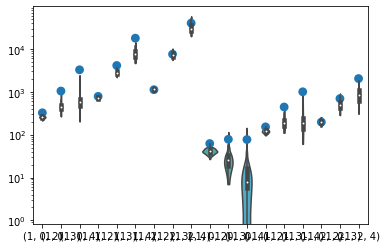

In [198]:
# comparisons = (1,slice(None),(2,3))
comparisons=slice(None)
sns.violinplot(data=n_pair_all_n_co_d_l.loc[comparisons,:].T,cut=0)
ax=sns.pointplot(data=n_pair_all_n_co_d.to_frame().loc[comparisons,:].T,join=False)
ax.set(yscale='log')

# example heatmaps

In [5]:
import plot_all_fr_map_x_pwc_one_session as plotfm

In [9]:
ani='e15_13f1'
sess='e15_13f1_220117'
all_fields=all_fields_recombined_all.loc[ani,sess]
fr_map_trial_df=fr_map_trial_df_all.loc[ani,sess]
X_raw = X_raw_all.loc[ani,sess]
X_pwc=X_pwc_all.loc[ani,sess]
all_sw_d = all_sw_d_all.loc[ani,sess]
spk_beh_df = spk_beh_df_all.loc[ani,sess]
trial_index_to_index_within_df = dpp.trial_index_to_index_within_trialtype(spk_beh_df)
index_within_to_trial_index_df = dpp.index_within_to_trial_index(spk_beh_df)

/tmp/ipykernel_336353/4256628755.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_fields=all_fields_recombined_all.loc[ani,sess]
/tmp/ipykernel_336353/4256628755.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_df=fr_map_trial_df_all.loc[ani,sess]
/tmp/ipykernel_336353/4256628755.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  X_raw = X_raw_all.loc[ani,sess]
/tmp/ipykernel_336353/4256628755.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  X_pwc=X_pwc_all.loc[ani,sess]
/tmp/ipykernel_336353/4256628755.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_sw_d = all_sw_d_all.loc[ani,sess]
/tmp/ipykernel_336353/4256628755.py:8: PerformanceWarning: indexing past lexsort depth may impact performance.
  spk_beh_df = spk_beh_df_all.loc[ani,sess]


In [13]:
all_fields_row_one = all_fields.iloc[1]

(<Figure size 864x288 with 3 Axes>,
 array([<Axes: xlabel='Peak firing rate (Hz)', ylabel='Trial'>,
        <Axes: xlabel='Pos. bin'>], dtype=object))

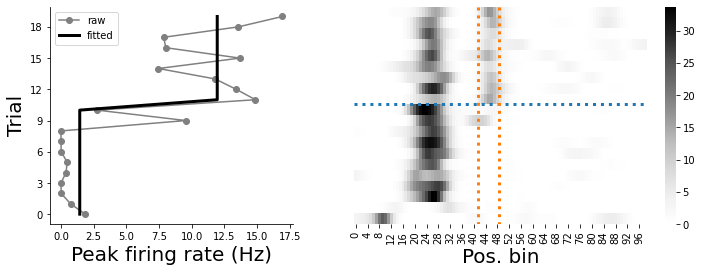

In [14]:
plotfm.plot_ratemap_fr_one_field(all_fields_row_one,fr_map_trial_df,X_raw,X_pwc,all_sw_d,
                            trial_index_to_index_within_df,)

In [125]:
X_raw.loc[(task_ind,tt,uid,0),:].dropna().shape

(20,)

In [134]:
all_sw_d

trialtype  uid  field_index         time  speed_gauss  field_pos  \
0 0        both   66            0  6684.468867    27.401026       25.0   
  1        both   67            0  6683.535300    30.506287        8.0   
  2        both  186            0  6684.402200    30.468344       24.0   
  3        both  329            0  6684.035433    40.542415       17.0   
  4        both  349            0  6684.035433    40.542415       17.0   
...         ...  ...          ...          ...          ...        ...   
  201       0.0  181            1  8222.942500    11.502441       43.0   
  202       0.0  204            0  8220.241800     8.558946       35.0   
  203       0.0  250            0  8242.805858    19.295595       83.0   
  204       0.0  313            1  8234.245367    15.980170       56.0   
  205       0.0  357            1  8223.709333    11.951551       49.0   

       trial_index  switch  index_within  switch_trial  switch_trial_frac  \
0 0              2     1.0             1           2.0             0.0625   
  1              2     1.0             1           2.0             0.0625   
  2              2     1.0             1           2.0             0.0625   
  3              2     1.0             1           2.0             0.0625   
  4              2     1.0             1           2.0             0.0625   
...            ...     ...           ...           ...                ...   
  201           30     1.0            18          18.0             0.9000   
  202           30     1.0            18          18.0             0.9000   
  203           30     1.0            18          18.0             0.9000   
  204           30     1.0            18          18.0             0.9000   
  205           30    -1.0            18          18.0             0.9000   

       pre_ntrials_in_segment  post_ntrials_in_segment  
0 0                         2                       30  
  1                         2                       23  
  2                         2                        7  
  3                         2                        7  
  4                         2                       10  
...                       ...                      ...  
  201                      18                        2  
  202                       4                        2  
  203                      18                        2  
  204                      18                        2  
  205                       2                        2  

[206 rows x 13 columns]

In [170]:
all_sw_d.loc[0].query('uid==@uid')

,trialtype,uid,field_index,time,speed_gauss,field_pos,trial_index,switch,index_within,switch_trial,switch_trial_frac,pre_ntrials_in_segment,post_ntrials_in_segment
2,both,186,0,6684.402200,30.468344,24.0,2,1.0,1,2.0,0.06250,2,7
47,both,186,0,7039.775667,16.649532,24.0,9,-1.0,5,9.0,0.28125,7,23


In [172]:
index_within_to_trial_index_df

   tt_ind  index
0  0.0     0         0
           1         2
           2         4
           3         6
           4        11
           5        12
           6        13
           7        15
           8        17
           9        18
           10       20
           11       21
           12       23
           13       24
           14       26
           15       27
           16       28
           17       29
           18       30
           19       31
   1.0     0         1
           1         3
           2         5
           3         7
           4         8
           5         9
           6        10
           7        14
           8        16
           9        19
           10       22
           11       25
Name: trial_ind, dtype: int64

> /mnt/home/szheng/projects/place_variability/code/plot_all_fr_map_x_pwc_one_session.py(74)plot_ratemap_one_neuron_all_fields()
     72             sw_trial_in_tt_ma=np.array([x in index_within_to_trial_index_df.loc[task_ind,tt].values for x in trial_index_l])
     73             pdb.set_trace()
---> 74             index_within_l_in_tt = index_within_l[sw_trial_in_tt_ma] # need to filter some of the index within, because they don't occur in the trial type, for the "both" fields
     75             if len(index_within_l_in_tt)>0:
     76                 xlim = (st-5,ed+5)

ipdb> c


/mnt/home/szheng/projects/place_variability/code/plot_all_fr_map_x_pwc_one_session.py:142: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_yticklabels(np.array(axs[0].get_yticks().tolist(),dtype=int))


(<Figure size 1200x400 with 3 Axes>,
 array([<Axes: xlabel='Firing Rate (Hz)', ylabel='Trial (within trial type)'>,
        <Axes: xlabel='Pos. bin'>], dtype=object))

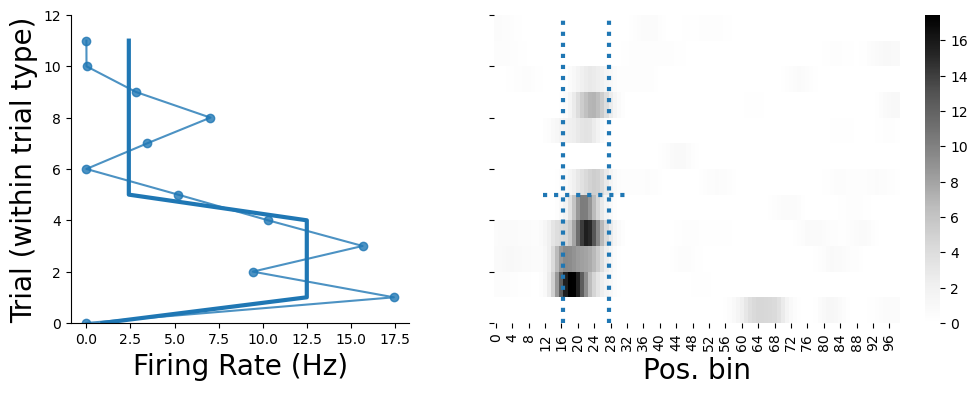

In [188]:
reload(ph)
import plot_all_fr_map_x_pwc_one_session as plotfm
reload(plotfm)

flipy=True
task_ind=0
tt=1
uid=186

plotfm.plot_ratemap_fr_one_neuron_all_fields(fr_map_trial_df,all_fields,X_raw,X_pwc,all_sw_d,index_within_to_trial_index_df,
                                       task_ind,tt,uid,flipy=True,
                                       fig=None,axs=None)

In [128]:
fr_map_trial_df.loc[(task_ind,tt,uid)].dropna(axis=1,how='all')

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.0,0.0,0.000000,0.001992,0.031117,0.647006,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.151014,0.0,0.0,3.083478,0.0,0.277002,0.043750
1,0.0,0.0,0.000000,0.005044,0.055477,0.712321,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.190120,0.0,0.0,3.640713,0.0,0.289149,0.096328
2,0.0,0.0,0.000000,0.012156,0.103291,0.778045,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.233976,0.0,0.0,4.278503,0.0,0.293766,0.223564
3,0.0,0.0,0.000000,0.025870,0.171918,0.794952,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.264148,0.0,0.0,4.650345,0.0,0.284188,0.460571
4,0.0,0.0,0.000000,0.051581,0.255939,0.757250,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.277574,0.0,0.0,4.669669,0.0,0.262951,0.833858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,0.0,0.0,2.629589,0.000000,0.000000,0.002114,0.0,0.0,0.0,0.0,...,0.0,0.187511,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
95,0.0,0.0,3.522539,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.296023,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
96,0.0,0.0,4.157483,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.392365,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
97,0.0,0.0,4.540457,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.462040,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Firing Rate (Hz)', ylabel='Trial (within trialtype)'>)

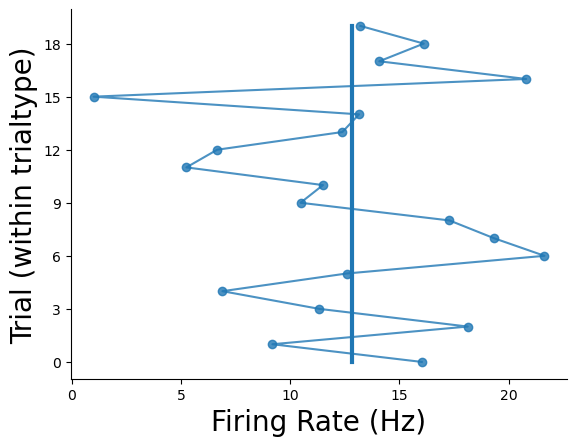

In [111]:
plot_x_raw_pwc_one_neuron_all_fields(X_raw,X_pwc,all_fields,all_sw_d,
                                       task_ind,tt,uid,flipy=True,
                                       fig=None,ax=None)

In [90]:
X_pwc.loc[task_ind,tt,]

0          1          2          3          4   \
0 0.0  31  1  11.860302        NaN  11.860302        NaN  11.860302   
       32  1   1.434035        NaN   1.434035        NaN   1.434035   
       34  0   4.093238        NaN   4.093238        NaN   4.093238   
       35  1   3.495219        NaN   3.495219        NaN   3.495219   
       36  0   8.683220        NaN   8.683220        NaN   8.683220   
...                 ...        ...        ...        ...        ...   
  both 363 0   7.453740   7.453740   7.453740   7.453740   7.453740   
       368 0   4.221207   4.221207   4.221207   4.221207   4.221207   
       370 0   1.875981   1.875981   1.875981   1.875981   1.875981   
       374 0  15.428028  15.428028  15.428028  15.428028  15.428028   
       376 0  16.181012  16.181012  16.181012  16.181012  16.181012   

                     5          6          7          8          9   ...  60  \
0 0.0  31  1        NaN  11.860302        NaN        NaN        NaN  ... NaN   
       32  1        NaN   1.434035        NaN        NaN        NaN  ... NaN   
       34  0        NaN   4.093238        NaN        NaN        NaN  ... NaN   
       35  1        NaN   3.495219        NaN        NaN        NaN  ... NaN   
       36  0        NaN   8.683220        NaN        NaN        NaN  ... NaN   
...                 ...        ...        ...        ...        ...  ...  ..   
  both 363 0   7.453740   7.453740   7.453740   7.453740   7.453740  ... NaN   
       368 0   4.221207   4.221207   4.221207   4.221207   4.221207  ... NaN   
       370 0   1.875981   1.875981   1.875981   1.875981   1.875981  ... NaN   
       374 0  15.428028  15.428028  15.428028  15.428028  15.428028  ... NaN   
       376 0  16.181012  16.181012  16.181012  16.181012   4.735479  ... NaN   

              61  62  63  64  65  66  67  68  69  
0 0.0  31  1 NaN NaN NaN NaN NaN NaN NaN NaN NaN  
       32  1 NaN NaN NaN NaN NaN NaN NaN NaN NaN  
       34  0 NaN NaN NaN NaN NaN NaN NaN NaN NaN  
       35  1 NaN NaN NaN NaN NaN NaN NaN NaN NaN  
       36  0 NaN NaN NaN NaN NaN NaN NaN NaN NaN  
...           ..  ..  ..  ..  ..  ..  ..  ..  ..  
  both 363 0 NaN NaN NaN NaN NaN NaN NaN NaN NaN  
       368 0 NaN NaN NaN NaN NaN NaN NaN NaN NaN  
       370 0 NaN NaN NaN NaN NaN NaN NaN NaN NaN  
       374 0 NaN NaN NaN NaN NaN NaN NaN NaN NaN  
       376 0 NaN NaN NaN NaN NaN NaN NaN NaN NaN  

[682 rows x 70 columns]

In [89]:
row

start                       33
end                         46
com                         40
peak                        41
fr_peak              11.613449
fr_mean               6.499159
other_field_index          NaN
Name: (0, 0.0, 111, 0), dtype: object

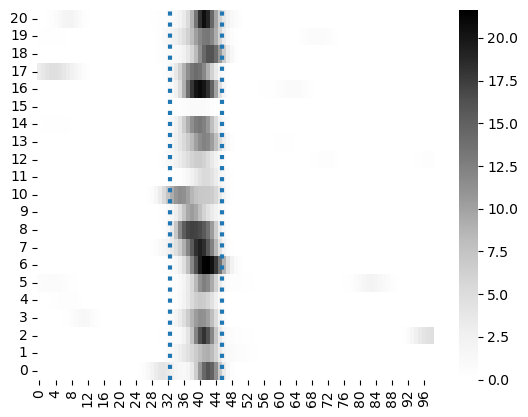

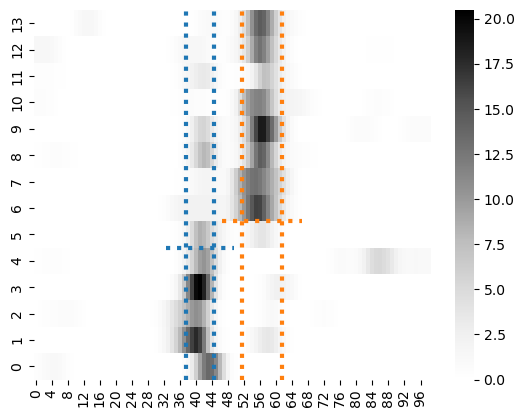

In [86]:
for tt in [0,1]:
    fig,ax=plot_ratemap_one_neuron_all_fields(fr_map_trial_df,all_fields,all_sw_d,task_ind,tt,uid,flipy=flipy,plot_fr=plot_fr,
                                         )

In [82]:
all_sw_d_sub

,trialtype,uid,field_index,time,speed_gauss,field_pos,trial_index,switch,index_within,switch_trial,switch_trial_frac,pre_ntrials_in_segment,post_ntrials_in_segment
39,1.0,111,0,7047.144200,14.059008,41.0,9,-1.0,5,5.0,0.416667,5,7
56,1.0,111,1,7092.672417,13.607071,55.0,10,1.0,6,6.0,0.500000,6,6


In [34]:
all_fields_sub

,,,,start,end,com,peak,fr_peak,fr_mean,other_field_index
,,,field_index,,,,,,,
0,0.0,100,0,77,89,83,83,5.20183,3.541209,NaN


In [30]:
reload(ph)

<module 'plot_helper' from '/mnt/home/szheng/projects/util_code/plot_helper.py'>

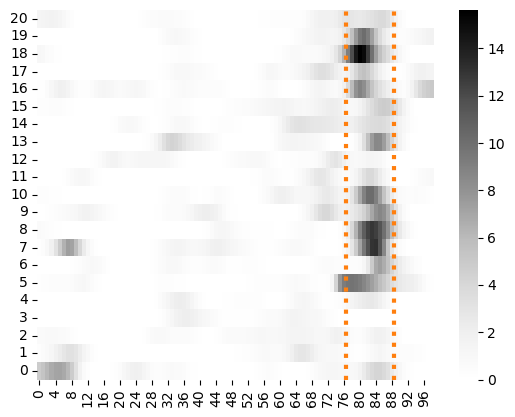

In [32]:
fig